In [7]:
from qiskit import QuantumCircuit,transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
import numpy as np

In [8]:
S0 = 100  # Initial price of the underlying asset
K = 100   # Strike price
T = 1     # Time to expiration
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility of the underlying asset

# Discretization parameters
n = 4 # Number of qubits for log-returns (2^n = N possible log-returns)
p = 3  # Number of qubits for payoff register

# Chebyshev polynomial degree for QSP
degree = 5

In [9]:
def prepare_log_return_state(circuit, qubits, probs):
    """Prepare the state with log-returns encoded in amplitudes."""
    # Assume probs is a list of probabilities for each possible log-return
    n = len(qubits)
    for i, p in enumerate(probs):
        # Prepare superposition based on the probability amplitudes
        if p > 0:
            circuit.initialize([np.sqrt(1 - p), np.sqrt(p)], qubits[i])
    return circuit

# Create a quantum circuit with 'n' qubits for the log-returns
log_return_qubits = list(range(n))
circuit = QuantumCircuit(n)
probs = [0.2, 0.3, 0.1, 0.4]  # Example probabilities for each log-return
circuit = prepare_log_return_state(circuit, log_return_qubits, probs)


In [10]:
from numpy.polynomial.chebyshev import Chebyshev

def chebyshev_approx(f, degree, x):
    """Compute Chebyshev approximation of function f at point x."""
    # Generate Chebyshev coefficients for function f
    coefs = Chebyshev.fit(x, f(x), degree).coef
    return np.polynomial.chebyshev.chebval(x, coefs)

# Example payoff function max(0, S - K)
def payoff(S, K):
    return max(0, S - K)

# Generate polynomial approximation of the payoff
S_vals = np.linspace(S0 * np.exp(-3), S0 * np.exp(3), 100)
payoff_vals = np.array([payoff(S, K) for S in S_vals])
poly_approx = chebyshev_approx(lambda x: payoff_vals, degree, S_vals)

In [11]:
def apply_qsp(circuit, qubits, coefs):
    """Apply QSP operator using Chebyshev polynomial coefficients."""
    for i, coef in enumerate(coefs):
        # Phase shift corresponding to Chebyshev coefficient
        circuit.p(coef, qubits[i % len(qubits)])
    return circuit

# Apply QSP to the circuit
circuit = apply_qsp(circuit, log_return_qubits, poly_approx)

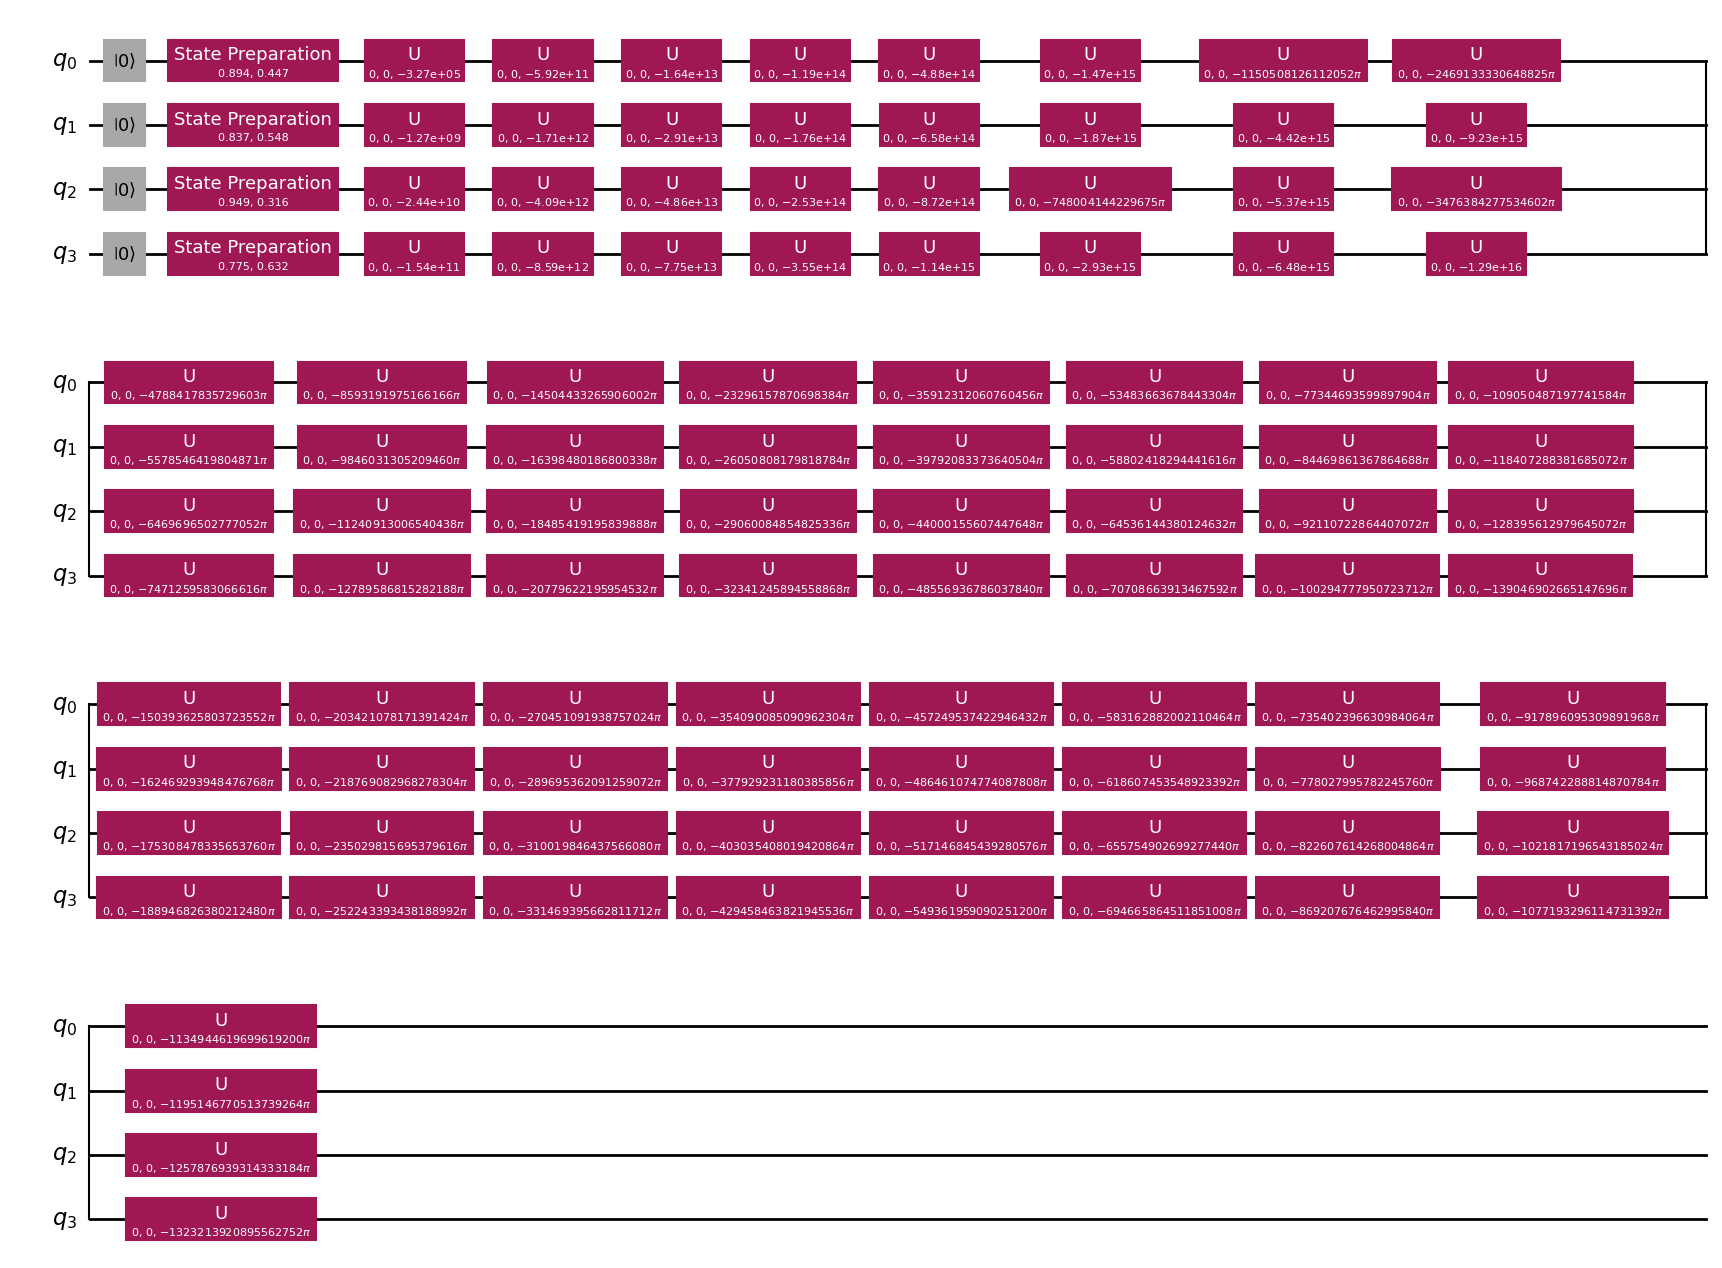

In [12]:
circuit.decompose().draw(output="mpl")

In [13]:
print(circuit.depth())

26


In [14]:
def measure_payoff_amplitude(circuit, qubits):
    """Measure the payoff amplitude."""
    # Add ancilla qubit for amplitude estimation
    circuit.measure_all()
    simulator = AerSimulator()
    compiled = transpile(circuit,simulator)
    job=simulator.run(compiled,shots=1000).result()
    counts = job.get_counts()
    return counts

# Run the circuit and measure the payoff amplitude
counts = measure_payoff_amplitude(circuit, log_return_qubits)
print(counts)

{'1000': 197, '0000': 314, '0001': 79, '1001': 55, '1010': 96, '1011': 19, '0010': 130, '0100': 31, '0101': 4, '0111': 4, '0011': 27, '0110': 10, '1100': 16, '1101': 7, '1110': 9, '1111': 2}


In [15]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService,SamplerV2 as Sampler 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

In [16]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True)

print(backend.name)

ibm_brisbane


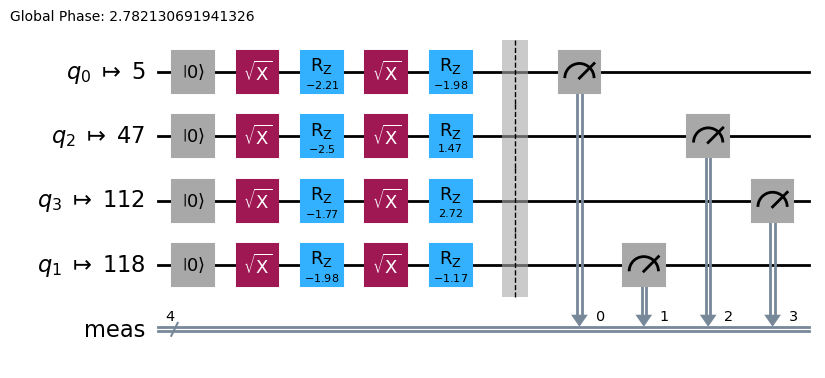

In [17]:
pm=generate_preset_pass_manager(optimization_level=3,backend=backend)
isa_circ=pm.run(circuit)

isa_circ.draw(output="mpl",idle_wires=False,fold=-1)

In [18]:
sampler=Sampler(mode=backend)
pubs=sampler.run([isa_circ],shots=1000)
print(f"Job Id: {pubs.job_id()}")

KeyboardInterrupt: 

In [48]:
result=pubs.result()[0]
counts=result.data.meas.get_counts()

print(counts)

{'1000': 195, '0010': 136, '0000': 299, '0110': 15, '1010': 84, '0001': 73, '1100': 30, '0101': 10, '0111': 3, '1001': 53, '0011': 27, '0100': 34, '1011': 26, '1110': 12, '1101': 1, '1111': 2}


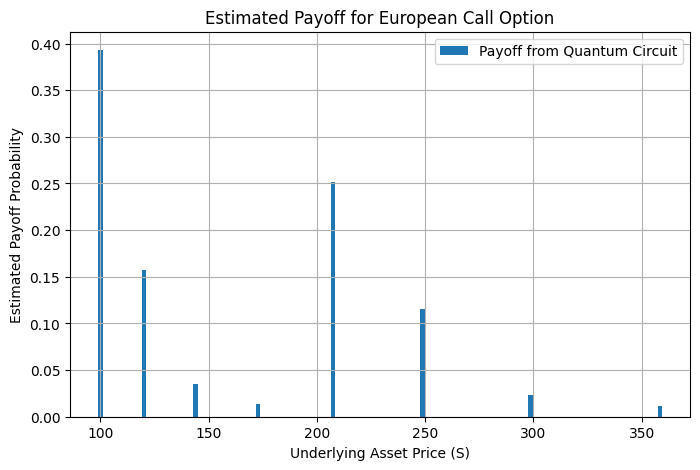

In [19]:
def state_to_price(state, S0=100, factor=1.2):
    """Convert quantum state to asset price."""
    # Example: State '000' maps to price S0, '001' maps to S0*factor, etc.
    state_int = int(state, 2)
    return S0 * (factor ** state_int)

# Extract measured states and compute corresponding payoffs
payoffs = {}
for state, count in counts.items():
    asset_price = state_to_price(state[:3])  # First 3 bits represent the asset price
    payoff = max(0, asset_price - K)  # Compute the payoff for the call option
    payoffs[asset_price] = payoffs.get(asset_price, 0) + count

# Normalize counts to probabilities
total_counts = sum(counts.values())
payoff_probs = {price: payoff / total_counts for price, payoff in payoffs.items()}

# Plot the payoff values based on the simulated results
prices = list(payoff_probs.keys())
payoff_values = list(payoff_probs.values())

plt.figure(figsize=(8, 5))
plt.bar(prices, payoff_values, width=2.0, label='Payoff from Quantum Circuit')
plt.title('Estimated Payoff for European Call Option')
plt.xlabel('Underlying Asset Price (S)')
plt.ylabel('Estimated Payoff Probability')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
from qiskit import QuantumCircuit,transpile
import numpy as np
from qiskit.circuit.library import UGate

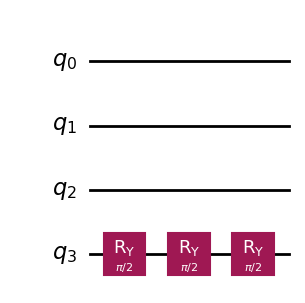

In [21]:
def U_sqrt(qc,x,n,ancilla):
    theta=2*np.arcsin(np.sqrt(x))
    for i in range (n):
        qc.cry(theta,i,ancilla)
    return qc 
def U_sin(qc,x,n,ancilla):
    for i in range (n):
        qc.ry(2*x,ancilla)
    return qc 
n_qubits = 3  # Example with 3 qubits
ancilla_qubit = n_qubits  # Ancilla is the next qubit

# Initialize a quantum circuit with n + 1 qubits
qc = QuantumCircuit(n_qubits + 1)

# Apply the U_sin gate (rotation based on sin(x))
x_value = np.pi / 4  # Example value for x (45 degrees)
U_sin(qc, x_value, n_qubits, ancilla_qubit)

U_sin=qc.to_gate()
# Draw the circuit
qc.draw('mpl')

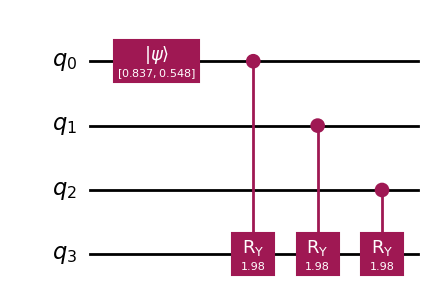

In [22]:
n_qubits = 3  # Example with 3 qubits
ancilla_qubit = n_qubits  # Ancilla is the next qubit

# Initialize a quantum circuit with n + 1 qubits
qc = QuantumCircuit(n_qubits + 1)

# Example state preparation (|x⟩ on n qubits)
x_value = 0.7  # Example value for x
initial_state = [np.sqrt(x_value), np.sqrt(1 - x_value)]  # Superposition of sqrt(x), sqrt(1-x)
qc.initialize(initial_state, 0)  # Initialize first qubit as |x>

# Apply the U_sqrt gate
U_sqrt(qc, x_value, n_qubits, ancilla_qubit)

qc.draw(output="mpl")


In [23]:
import numpy as np

# Define the number of qubits
n = 3  # For example, 3 qubits for |x>n and 2 ancilla qubits

# Create a Quantum Circuit with 5 qubits (3 for |x>n, 2 ancillas)
qc = QuantumCircuit(n + 2)

# Define parameters (phase angles φ from the equations)
phi_d = np.pi / 4   # Replace with actual value
phi_d_minus_1 = np.pi / 6  # Replace with actual value
phi_1 = np.pi / 8  # Replace with actual value

# First Hadamard gate on ancilla qubit 0
qc.h(n)

In [24]:
qc.unitary(UGate(2 * np.pi, np.pi, np.pi), [0, 1, 2], label="U")

# Apply controlled-Rz rotations as described in the circuit
qc.crz(-2 * phi_d, n, n + 1)
qc.crz(-2 * phi_d_minus_1, n, n + 1)

# Apply the daggered version of U (U†)
qc.unitary(UGate(-2 * np.pi, -np.pi, -np.pi), [0, 1, 2], label="U†")

# Apply controlled-Rz rotations again
qc.crz(-2 * phi_1, n, n + 1)

# Apply the final U gate if d is odd
qc.unitary(UGate(2 * np.pi, np.pi, np.pi), [0, 1, 2], label="U")

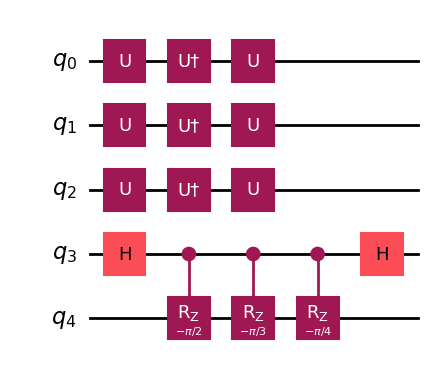

In [25]:
qc.h(n)

# Draw the circuit
qc.draw(output='mpl')


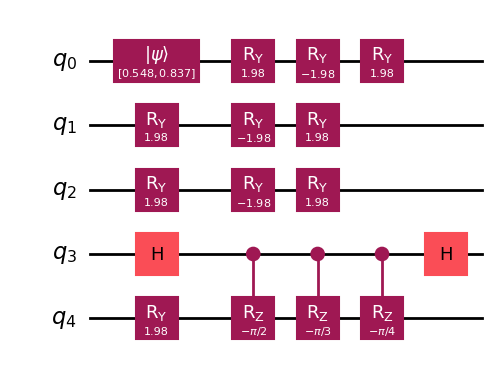

In [26]:
n = 3  # Number of qubits in |x>n
qc = QuantumCircuit(n + 2)  # +2 for ancilla qubits

# Define x, which controls the rotation
x = 0.3  # Example value of x, replace with actual value
x_load=np.sqrt(x)
y_load=np.sqrt(1-x)
qc.initialize(params=[x_load,y_load],qubits=0)
# Define the state |psi_0> and |psi_1> as placeholder gates
# Assuming |psi_0> and |psi_1> are general states, you can adjust them as needed.
# For simplicity, let's assume they are identity states or can be modified based on your setup.

# Apply the U_sqrt operation
# We need to create a superposition sqrt(x) |0> + sqrt(1-x) |1> on the ancilla qubit

theta = 2 * np.arccos(np.sqrt(x))  # Calculate the rotation angle to achieve sqrt(x)|0> + sqrt(1-x)|1>

# Apply Ry rotation to the last ancilla qubit (at n+1)
qc.ry(theta, n + 1)

# The rest of the circuit follows, incorporating this U_sqrt operation as the U

# First Hadamard gate on ancilla qubit 0
qc.h(n)

# First block encoding unitary U (which is now our Ry gate for U_sqrt)
qc.ry(theta, [0, 1, 2])

# Apply controlled-Rz rotations as described in the circuit
phi_d = np.pi / 4   # Replace with actual value
phi_d_minus_1 = np.pi / 6  # Replace with actual value
phi_1 = np.pi / 8  # Replace with actual value

qc.crz(-2 * phi_d, n, n + 1)
qc.crz(-2 * phi_d_minus_1, n, n + 1)

# Apply the daggered version of U (U†) - which is the inverse of the Ry gate
qc.ry(-theta, [0, 1, 2])

# Apply controlled-Rz rotations again
qc.crz(-2 * phi_1, n, n + 1)

# Apply the final U gate if d is odd (Ry rotation again)
qc.ry(theta, [0, 1, 2])

# Final Hadamard gate on ancilla qubit 0
qc.h(n)

# Draw the circuit
qc.draw(output='mpl')

In [27]:
from qiskit.circuit.library import RYGate, RZGate, HGate
import numpy as np

# Parameters
A = 1  # Coefficient for f(x), can be modified
B = 0.5  # Coefficient for f(x), can be modified
C = 2  # Coefficient for f(x), can be modified
p = 2  # Binary precision, can be adjusted
n = 3  # Number of qubits representing |x⟩
m = 1  # Additional ancilla qubits

# Function f(x)
def f(x):
    return np.sqrt((A * np.exp(2 * x) - B) / C)

# Create the circuit with n + m + 1 qubits
qc = QuantumCircuit(n + m + 1)

# Superposition on the |x⟩ register, the first n qubits
qc.h(range(n))

# Apply the comparison operation
# Binary comparison: U_sqrt
for i in range(n):
    qc.ry(2 * np.arcsin(np.sqrt(i / (2 ** n))), i)  # Encodes sqrt(x)
qc.cry(2 * np.arcsin(np.sqrt(1 / 2 ** n)), n - 1, n)  # Controlled sqrt operation

# Apply the controlled binary comparison using C
# Controlled comparison between |x⟩n and ancillary
for i in range(n):
    qc.cx(i, n + 1)

# Apply H gates on ancilla
qc.h(n)

# Polynomial part (Chebyshev approximation using U_sqrt)
# This is for the polynomial P(x) ≈ f(x)
def apply_polynomial(qc, degree, coefficients):
    """ Applies polynomial using even Chebyshev polynomials on a given quantum circuit """
    for i in range(degree):
        theta = np.arccos(coefficients[i])
        qc.ry(2 * theta, i)

# Define the Chebyshev coefficients for the polynomial approximation of f(x)
coefficients = [0.8, 0.5, 0.3]  # Example coefficients for a degree-2 polynomial
apply_polynomial(qc, len(coefficients), coefficients)

# Apply controlled Ry rotation for f(x)
for i in range(n):
    qc.cry(2 * np.arcsin(np.sqrt(f(i / (2 ** n)))), i, n + 1)

# Apply U_sqrt as defined
# U_sqrt transforms the binary x into |ψ0⟩ and |ψ1⟩ states
for i in range(n):
    theta = np.arcsin(np.sqrt(i / (2 ** n)))
    qc.ry(2 * theta, i)
    qc.cry(2 * theta, i, n + 1)

# Finalize the circuit by applying the QSP part
qc.barrier()
qc.measure_all()

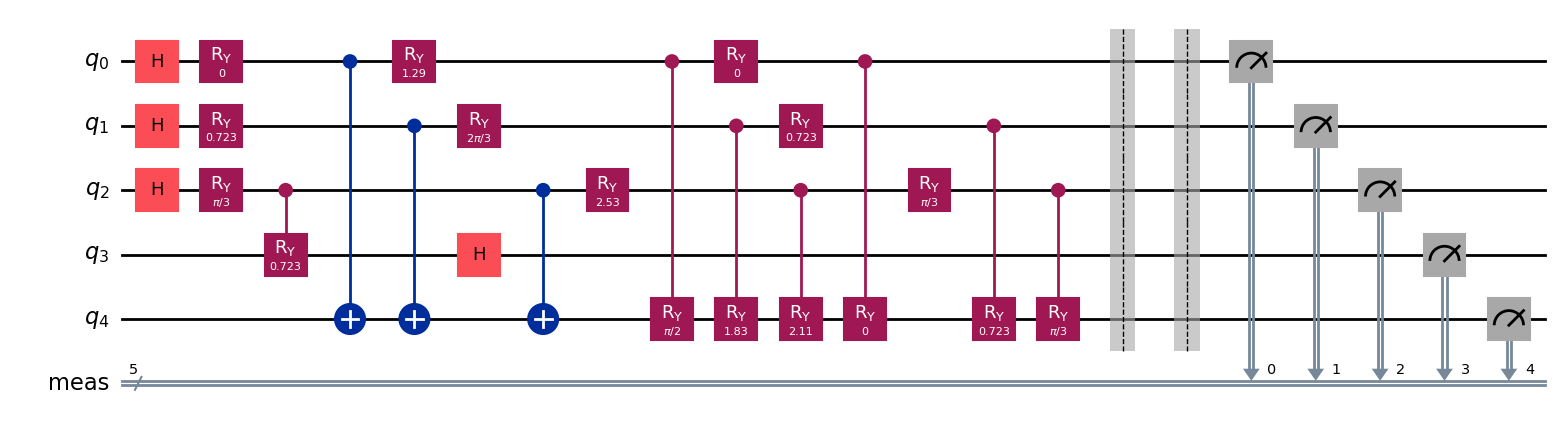

In [28]:
qc.draw(output="mpl")

In [29]:
import numpy as np
from scipy.optimize import minimize
from numpy.polynomial.chebyshev import chebval, Chebyshev
from qiskit import QuantumCircuit

In [30]:
A = 1
B = 0.5
C = 2
degree = 4

In [31]:
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt 

In [32]:
def U_sin_gate(x):
    # Define the unitary matrix for U_sin
    sin_x = np.sin(x)
    cos_x = np.cos(x)

    # The unitary matrix that applies U_sin on the ancilla qubit (2x2 matrix)
    U_sin_matrix = np.array([[sin_x, cos_x],
                             [-cos_x, sin_x]])

    # Create the custom gate using Qiskit's Operator class
    U_sin_gate = Operator(U_sin_matrix)

    return U_sin_gate

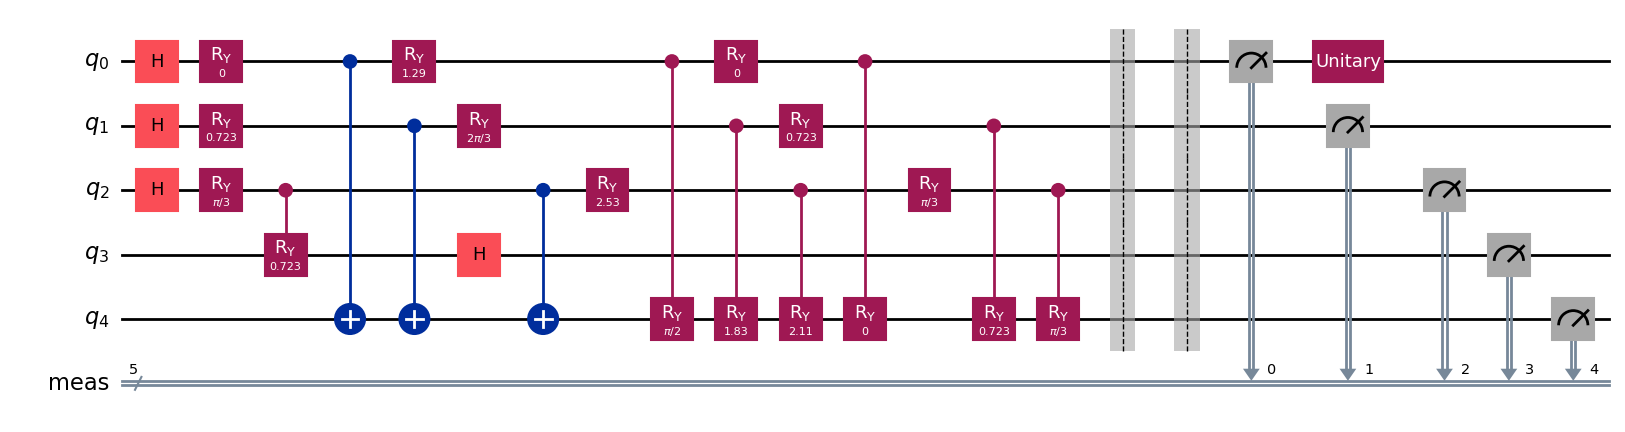

In [33]:
U_sin=U_sin_gate(0.2)
qc.append(U_sin,qargs=[0])

qc.draw("mpl")

In [34]:
def create_n_U_sqrt(x, n):
    # Ensure x is between 0 and 1
    n=n-1
    if x < 0 or x > 1:
        raise ValueError("x must be between 0 and 1")

    # Calculate components
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)

    # Define the unitary matrix for the first qubit and identity for others
    unitary_matrix = np.zeros((2**n, 2**n), dtype=complex)

    # Fill in the matrix for the transformation
    for i in range(2**(n-1)):
        unitary_matrix[0 + 2*i][0 + 2*i] = sqrt_x   # |0...0> to sqrt(x)|0...0>
        unitary_matrix[0 + 2*i][1 + 2*i] = sqrt_1_minus_x  # |0...0> to sqrt(1-x)|1...0>
        unitary_matrix[1 + 2*i][0 + 2*i] = -sqrt_1_minus_x # |0...0> to -sqrt(1-x)|1...0>
        unitary_matrix[1 + 2*i][1 + 2*i] = sqrt_x   # |1...0> to sqrt(x)|1...0>

    # Create a quantum circuit to apply this unitary
    qc = QuantumCircuit(n+1)
    
    U_sqrt=Operator(unitary_matrix)
    # Add the unitary gate to the circuit
    qc.append(U_sqrt, qargs=list(range(n)))

    return qc.decompose(),unitary_matrix

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

service=QiskitRuntimeService()
backend=service.least_busy(operational=True)

pm=generate_preset_pass_manager(optimization_level=3,backend=backend)

In [178]:
from qiskit_aer import QasmSimulator
simulator=QasmSimulator()


In [192]:


qubits=[]
cx_count=[]
depth_sqrt=[]

for i in range (2,8):
    qubits.append(i) 
    param=0.56
    qc,_=create_n_U_sqrt(param,i) 
    isa_circ=pm.run(qc)
    depth_sqrt.append(isa_circ.depth())
    print(isa_circ.count_ops())


OrderedDict([('sx', 2), ('rz', 2)])
OrderedDict([('sx', 2), ('rz', 2)])
OrderedDict([('rz', 90), ('sx', 58), ('ecr', 24), ('x', 2)])
OrderedDict([('rz', 501), ('sx', 309), ('ecr', 141), ('x', 16)])
OrderedDict([('rz', 1924), ('sx', 1182), ('ecr', 557), ('x', 67)])
OrderedDict([('rz', 9269), ('sx', 5875), ('ecr', 2713), ('x', 237)])


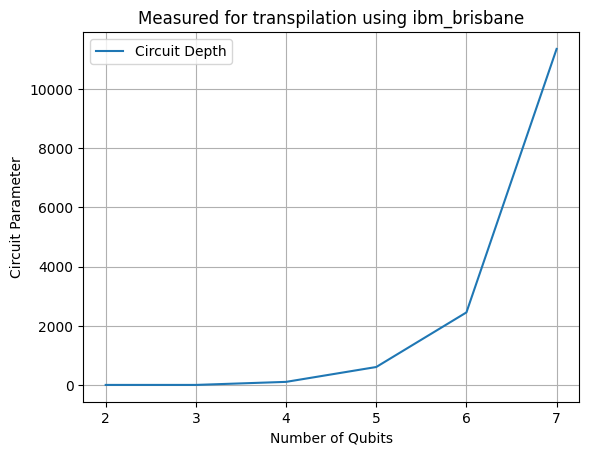

In [193]:
plt.plot(qubits,depth_sqrt,label="Circuit Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Parameter")
plt.title(f"Measured for transpilation using {backend.name}")
plt.legend()
plt.grid(True)
plt.show()

[[ 0.74833148+0.j  0.66332496+0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.66332496+0.j  0.74833148+0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.74833148+0.j  0.66332496+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.66332496+0.j  0.74833148+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.74833148+0.j  0.66332496+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -0.66332496+0.j  0.74833148+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.74833148+0.j  0.66332496+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   

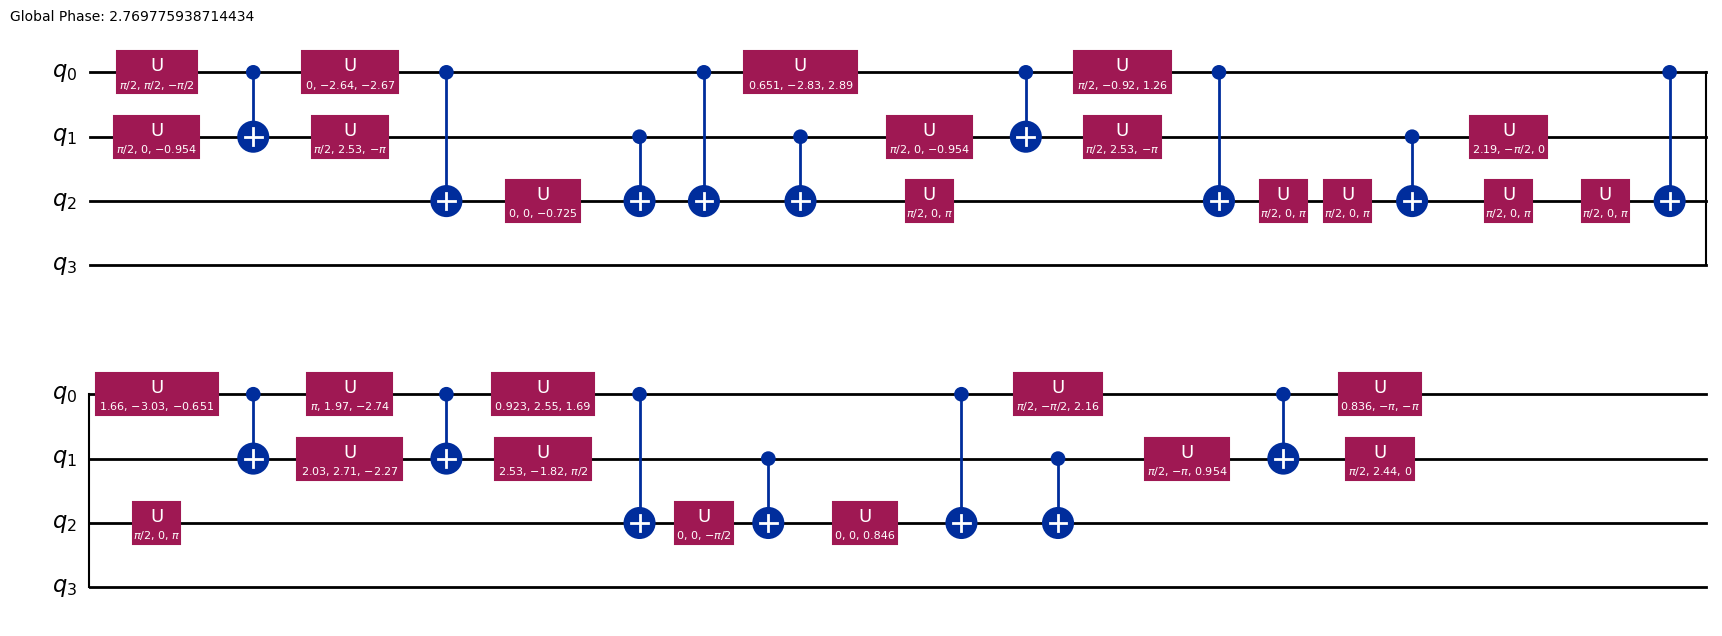

In [35]:
qc,matrix=create_n_U_sqrt(0.56,4)
print(matrix)
qc.decompose().draw(output="mpl")

ValueError: Input matrix is not unitary.

In [36]:
i,gate=general_U_sin(0.75,3)
print(i)

NameError: name 'general_U_sin' is not defined

In [151]:
u_matrix = np.array([[ 0.70710678+0.j, 0.70710678+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
                    [-0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
                    [ 0. +0.j, -0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
                    [ 0. +0.j, 0. +0.j, -0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
                    [ 0. +0.j, 0. +0.j, 0. +0.j, -0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0. +0.j, 0. +0.j],
                    [ 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, -0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0. +0.j],
                    [ 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, -0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j],
                    [ 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, -0.70710678+0.j, 0.70710678+0.j]])

# Make the matrix unitary
u_matrix = u_matrix / np.linalg.norm(u_matrix, axis=1, keepdims=True)

# Verify the matrix is unitary
if np.allclose(np.eye(2**3), u_matrix @ u_matrix.conj().T):
    print("The U_sin(θ) matrix is now unitary.")
else:
    print("The U_sin(θ) matrix is still not unitary.")

print(u_matrix)

The U_sin(θ) matrix is still not unitary.
[[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.57735027+0.j  0.57735027+0.j  0.57735027+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.57735027+0.j  0.57735027+0.j  0.57735027+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.57735027+0.j  0.57735027+0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.57735027+0.j
   0.57735027+0.j  0.57735027+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -0.57735027+0.j  0.57735027+0.j  0.57735027+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j -0.57735027+0.j  0.57735027+0.j  0.57735027+0.j]
 [ 0.        +0.j  0.      

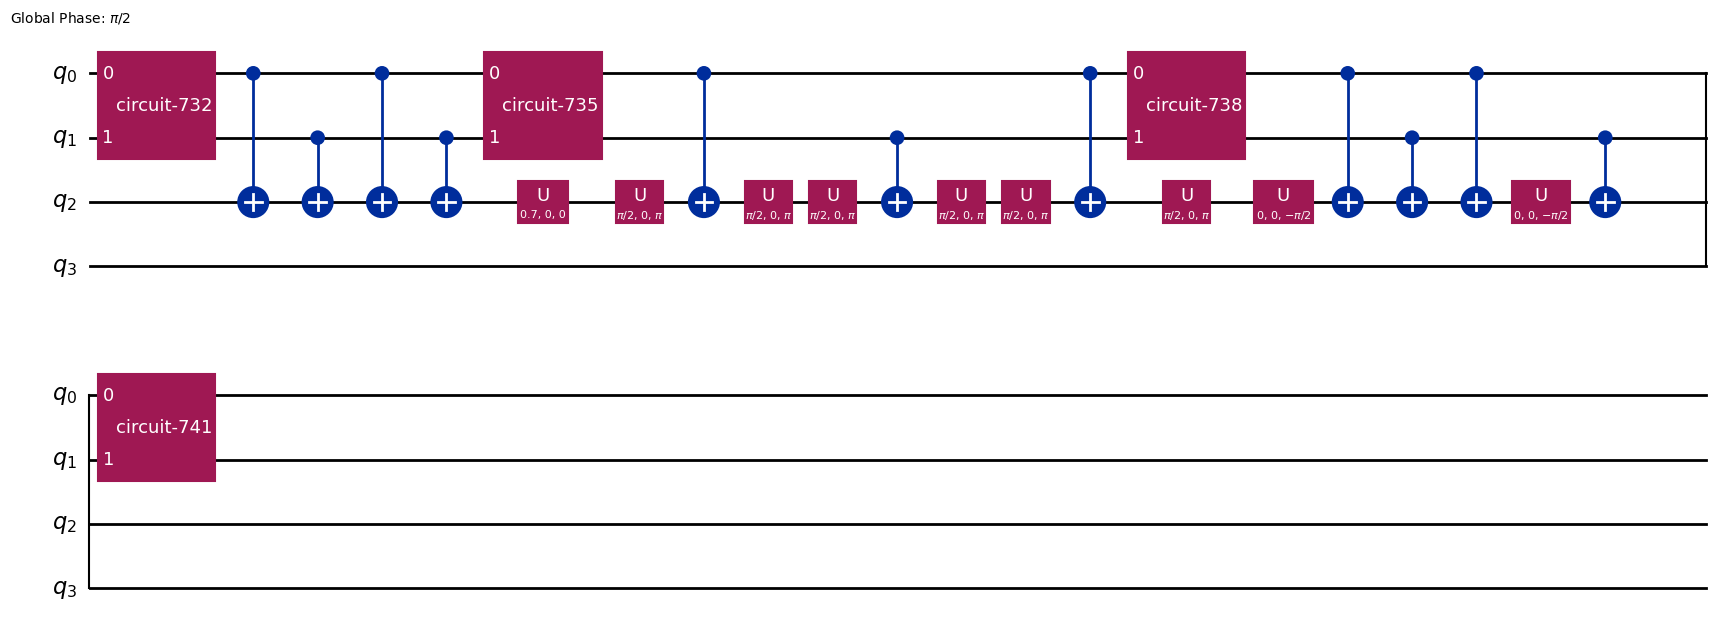

In [37]:
def u_sin_theta_matrix(x,n):
    n-=1
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        n (int): Number of qubits.
        
    Returns:
        numpy.ndarray: The U_sin(θ) unitary matrix.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
    U_sin=Operator(u_matrix) 
    qc=QuantumCircuit(n+1)
    qc.append(U_sin,qargs=list(range(n)))  
    return qc

# Generate the U_sin(θ) matrix for 3 qubits
n = 4
u_matrix = u_sin_theta_matrix(0.35,n)

u_matrix.decompose().draw(output="mpl")

In [194]:
qubits=[]
cx_count=[]
depth_sin=[]

for i in range (2,8):
    qubits.append(i) 
    param=0.56
    qc=u_sin_theta_matrix(param,i) 
    isa_circ=pm.run(qc)
    depth_sin.append(isa_circ.depth())
    print(isa_circ.count_ops())

OrderedDict([('rz', 2), ('sx', 2)])
OrderedDict([('rz', 4), ('sx', 4)])
OrderedDict([('rz', 65), ('sx', 45), ('ecr', 17), ('x', 1)])
OrderedDict([('rz', 586), ('sx', 382), ('ecr', 147), ('x', 5)])
OrderedDict([('rz', 3433), ('sx', 2157), ('ecr', 857), ('x', 30)])
OrderedDict([('rz', 15758), ('sx', 9740), ('ecr', 3965), ('x', 155)])


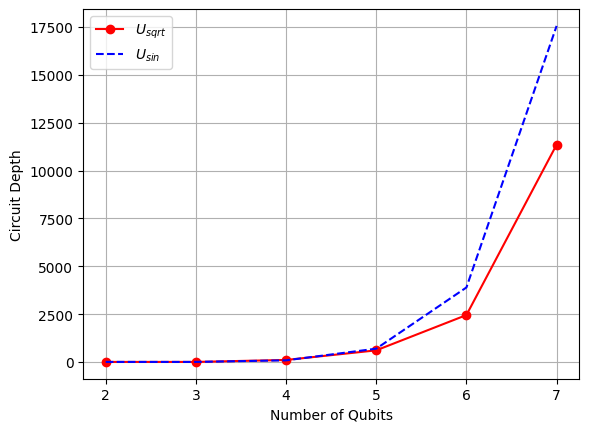

In [197]:
plt.plot(qubits,depth_sqrt,"ro-",label=r"$U_{sqrt}$")
plt.plot(qubits,depth_sin,"b--",label=r"$U_{sin}$")
plt.legend()
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.grid(True)
plt.show()

In [38]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

def create_u_sin_gate(theta, n):
    size = 2 ** n
    u_sin_matrix = np.zeros((size, size), dtype=complex)

    # Apply the transformation across all basis states for the qubits
    for i in range(size):
        # Apply sine and cosine transformation for each computational basis state
        u_sin_matrix[i][i] = np.sin(theta)   # Diagonal terms: sin(theta)
        if i + 1 < size:
            u_sin_matrix[i][i + 1] = np.cos(theta)   # Off-diagonal terms: cos(theta)
            u_sin_matrix[i + 1][i] = -np.cos(theta)  # Symmetric off-diagonal

    # Validate unitarity
    if not np.allclose(np.dot(u_sin_matrix.conj().T, u_sin_matrix), np.eye(size)):
        raise ValueError("Input matrix is not unitary.")
    
    # Create a quantum circuit to apply this unitary
    qc = QuantumCircuit(n)
    
    # Add the unitary gate to the circuit
    qc.append()
    return qc

# Example usage
theta = np.pi / 4  # Example angle for U_sin
n = 3  # Number of qubits
try:
    u_sin_gate_circuit = create_u_sin_gate(theta, n)
    print(u_sin_gate_circuit)
    u_sin_gate_circuit.draw('mpl')  # Optional: visualize the circuit
except ValueError as e:
    print(e)


Input matrix is not unitary.


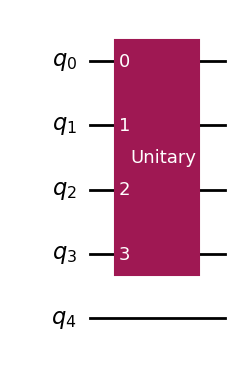

In [114]:
gate=create_n_qubit_gate(0.25,5)

gate.draw(output="mpl")


In [88]:
x = 0.75
n = 3  # Number of qubits
n_qubit_gate_circuit = create_n_qubit_gate(x, n)

# Print the resulting circuit
print(n_qubit_gate_circuit)
n_qubit_gate_circuit.draw('mpl')

TypeError: issubclass() arg 1 must be a class

   ┌─────────┐
q: ┤ Unitary ├
   └─────────┘


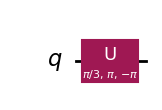

In [81]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit.library import UnitaryGate

def create_usqrt_gate(x):
    # Ensure x is between 0 and 1
    if x < 0 or x > 1:
        raise ValueError("x must be between 0 and 1")

    # Define the sqrt(x) and sqrt(1-x) terms
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)

    # Define the unitary matrix that implements the transformation
    # |x⟩n |0⟩n+1 -> sqrt(x)|ψ0⟩|0⟩ + sqrt(1-x)|ψ1⟩|1⟩
    unitary_matrix = np.array([
        [sqrt_x, sqrt_1_minus_x],  # Transforms |0⟩ to sqrt(x)|0⟩ + sqrt(1-x)|1⟩
        [-sqrt_1_minus_x, sqrt_x]  # Orthogonal component to keep unitarity
    ])

    # Create a QuantumCircuit with the unitary
    qc = QuantumCircuit(1)  # Only one qubit here for the unitary
    usqrt_gate = Operator(unitary_matrix)
    qc.append(usqrt_gate, [0])  # Apply to the qubit

    return qc

# Example value of x
x = 0.75
usqrt_circuit = create_usqrt_gate(x)

# Print the circuit
print(usqrt_circuit)

# Optionally, you can draw the circuit
usqrt_circuit.decompose().draw('mpl')


   ┌─────────┐┌─────────┐
q: ┤ Unitary ├┤ Unitary ├
   └─────────┘└─────────┘


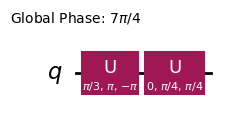

In [79]:
from qiskit import QuantumCircuit 
import numpy as np 
from qiskit.circuit.library import UnitaryGate

def apply_exp_gate(circuit,phi_d,target):
    sigma_z=np.array([
        [1,0],
        [0,-1]
    ])
    unitary=np.array([
        [np.exp(-1j*phi_d),0],
        [0,np.exp(1j*phi_d)]
    ])
    
    gate=UnitaryGate(unitary)
    circuit.append(gate,qargs=[0])
x = 0.75
phi_d = np.pi / 4  # Example angle
n = 1  # Number of qubits for |x⟩

# Create the circuit
usqrt_circuit = create_usqrt_gate(x)

# Apply the e^{-i * phi_d * sigma_z} ⊗ I gate
apply_exp_gate(usqrt_circuit, phi_d, 0)  # Apply on qubits 0 and 1

# Print the resulting circuit
print(usqrt_circuit)
usqrt_circuit.decompose().draw('mpl')



In [39]:
def f(x):
    return np.sqrt((A * np.exp(2 * x) - B) / C)

# Chebyshev minimax optimization to find the coefficients
def chebyshev_coefficients(degree, num_points=100):
    # Discretize x in [0, 1] (the interval we're interested in)
    x_points = np.linspace(0, 1, num_points)
    f_values = f(x_points)

    # Define a Chebyshev polynomial with unknown coefficients
    def polynomial(c):
        return chebval(x_points, c) - f_values

    # Minimax optimization to find best coefficients
    initial_guess = np.zeros(degree + 1)
    result = minimize(lambda c: np.max(np.abs(polynomial(c))), initial_guess)
    return result.x

In [40]:
cheb_coeffs = chebyshev_coefficients(degree)

# Print the Chebyshev coefficients
print("Chebyshev Coefficients:", cheb_coeffs)

# Quantum circuit implementation
n = 3  # Number of qubits for |x⟩_n
qc = QuantumCircuit(n + 1)  # +1 for ancilla

# Superposition of |x⟩
qc.h(range(n))

Chebyshev Coefficients: [ 0.84797034  0.67179195  0.38182083 -0.07999557  0.03656181]


In [41]:
def apply_u_sin(qc, n):
    for i in range(n):
        x = i / (2 ** n)  # Discrete approximation of x
        theta = 2 * np.arcsin(np.sin(x))  # Use sin(x) for the rotation angle
        qc.ry(theta, n)  # Ry rotation on the ancilla (last qubit) for sin(x)

        # Apply controlled-NOT from qubit |x⟩ to ancilla to flip ancilla if |x⟩ = 1
        qc.cx(i, n)
# Apply U_sin
apply_u_sin(qc, n)

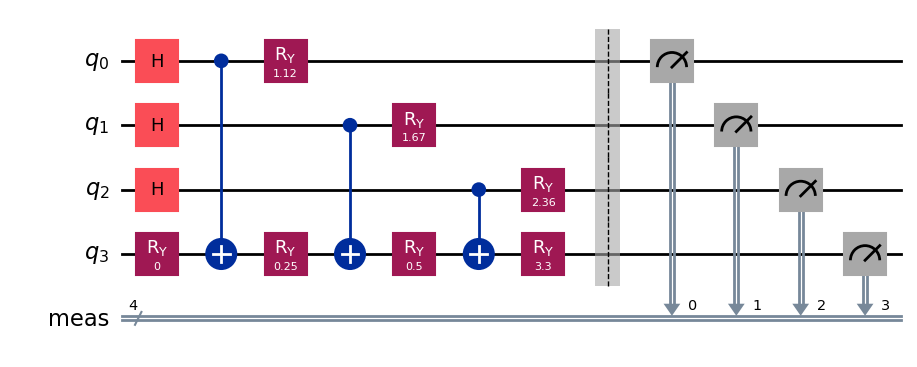

In [42]:
def apply_polynomial(qc, degree, coefficients):
    for i in range(degree):
        theta = np.arccos(coefficients[i])  # Rotation angle based on Chebyshev coefficient
        qc.ry(2 * theta, i)

# Apply the polynomial approximation of f(x) using Chebyshev coefficients
apply_polynomial(qc, len(cheb_coeffs)-1, cheb_coeffs)

qc.measure_all()

qc.draw(output="mpl")

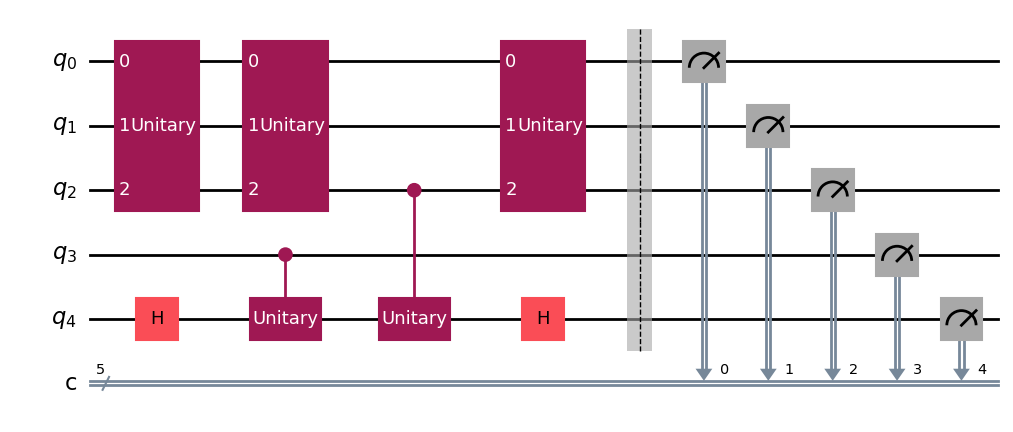

In [47]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Define the u_sin_theta_matrix function
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n+1)  # n qubits + 1 auxiliary qubit
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control, target):
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    circuit.append(gate.control(1), qargs=[control, target])

# Now construct the full circuit
n = 3 # Number of qubits in the main register
theta = np.pi / 4  # Parameter for U_sin gate
phi_d = np.pi / 3  # Phase for the exponential gates

# Create the quantum circuit
qc = QuantumCircuit(n + 2, n + 2)  # n qubits + 2 auxiliary qubits

# Apply Hadamard gate to the auxiliary qubit (last qubit)
qc.h(n+1)

# Create the U_sin(θ) gate and apply it to the top n-qubit register
u_sin_gate = u_sin_theta_matrix(theta, n)
qc.compose(u_sin_gate, qubits=range(n+1), inplace=True)

# Apply the controlled exponential gate with the specified phase
apply_exp_gate(qc, phi_d, control=n, target=n+1)

# Apply U† (inverse of U_sin)
u_sin_dagger = u_sin_gate.inverse()
qc.compose(u_sin_dagger,qubits=range(n+1), inplace=True)

# Apply another controlled exponential gate
apply_exp_gate(qc, phi_d, control=n-1, target=n+1)

# Apply another U_sin if d is odd (we assume d is odd here)
qc.compose(u_sin_gate, qubits=range(n+1), inplace=True)

# Final Hadamard gate on the auxiliary qubit
qc.h(n+1)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 2), range(n + 2))


# Draw the circuit
qc.draw('mpl')


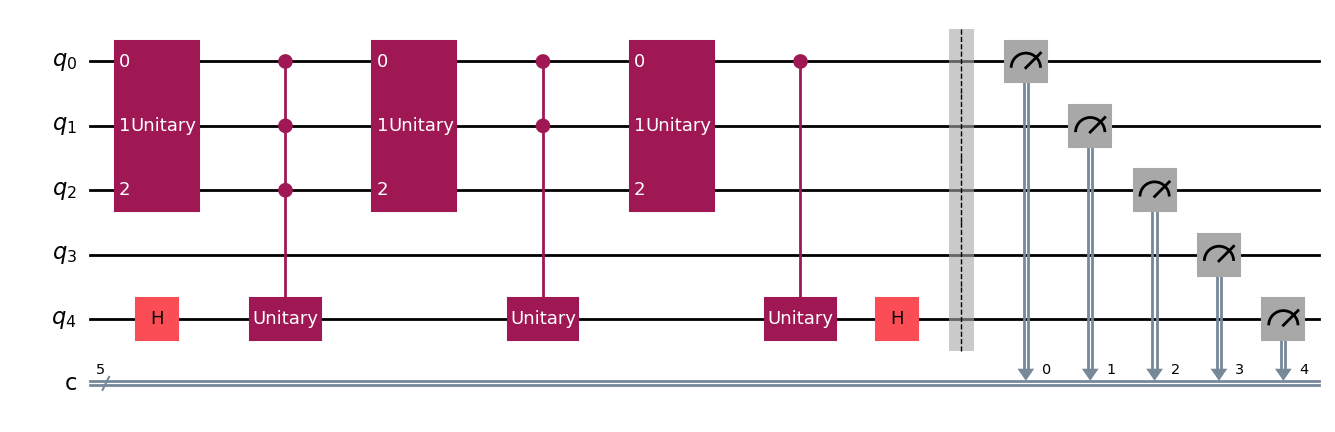

In [50]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n+1)  # n qubits + 1 auxiliary qubit
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n)
theta = np.pi / 4  # Parameter for U_sin gate
phi_d_1 = np.pi / 3  # Phase for the first controlled exponential gate
phi_d_2 = np.pi / 5  # Phase for the second controlled exponential gate
phi_d_3 = np.pi / 7  # Phase for the third controlled exponential gate (if d is odd)

# Create the quantum circuit
qc = QuantumCircuit(n + 2, n + 2)  # n qubits + 2 auxiliary qubits

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n+1)

# Apply the first U_sin(θ) gate
u_sin_gate = u_sin_theta_matrix(theta, n)
qc.compose(u_sin_gate, qubits=range(n+1), inplace=True)

# Apply the first controlled exponential gate
apply_exp_gate(qc, phi_d_1, control_qubits=list(range(n)), target=n+1)

# Apply U† (inverse of U_sin)
u_sin_dagger = u_sin_gate.inverse()
qc.compose(u_sin_dagger, qubits=range(n+1), inplace=True)

# Apply the second controlled exponential gate
apply_exp_gate(qc, phi_d_2, control_qubits=list(range(n-1)), target=n+1)

# Apply the third U_sin(θ) gate (only if d is odd)
qc.compose(u_sin_gate, qubits=range(n+1), inplace=True)

# Apply the third controlled exponential gate (only if d is odd)
apply_exp_gate(qc, phi_d_3, control_qubits=[0], target=n+1)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n+1)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 2), range(n + 2))

# Draw the circuit
qc.draw('mpl')


In [54]:
import random

In [55]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n)  # Create circuit with only n qubits
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 4  # Number of qubits in the main register (n qubits for U and U†)
theta = np.pi / 4  # Parameter for U_sin gate

phi=np.random.uniform(low=-np.pi,high=np.pi,size=(5,))
phi_d_1 = np.pi / 3  # Phase for the first controlled exponential gate
phi_d_2 = np.pi / 5  # Phase for the second controlled exponential gate
phi_d_3 = np.pi / 7  # Phase for the third controlled exponential gate (if d is odd)

# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  
qc.h(n)# n qubits + 1 auxiliary qubit
for i in range (len(phi)):
    u_sin_gate = u_sin_theta_matrix(theta, n)
    qc.compose(u_sin_gate, qubits=range(n), inplace=True)

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n)

# Apply the first U_sin(θ) gate
u_sin_gate = u_sin_theta_matrix(theta, n)
qc.compose(u_sin_gate, qubits=range(n), inplace=True)

# Apply the first controlled exponential gate
apply_exp_gate(qc, phi_d_1, control_qubits=list(range(n)), target=n)

# Apply U† (inverse of U_sin)
u_sin_dagger = u_sin_gate.inverse()
qc.compose(u_sin_dagger, qubits=range(n), inplace=True)

# Apply the second controlled exponential gate
apply_exp_gate(qc, phi_d_2, control_qubits=list(range(n-1)), target=n)

if d%2==0:
# Apply the third U_sin(θ) gate (only if d is odd)
  qc.compose(u_sin_gate, qubits=range(n), inplace=True)
  apply_exp_gate(qc, phi_d_3, control_qubits=[0], target=n)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl')


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3617559161.py, line 50)

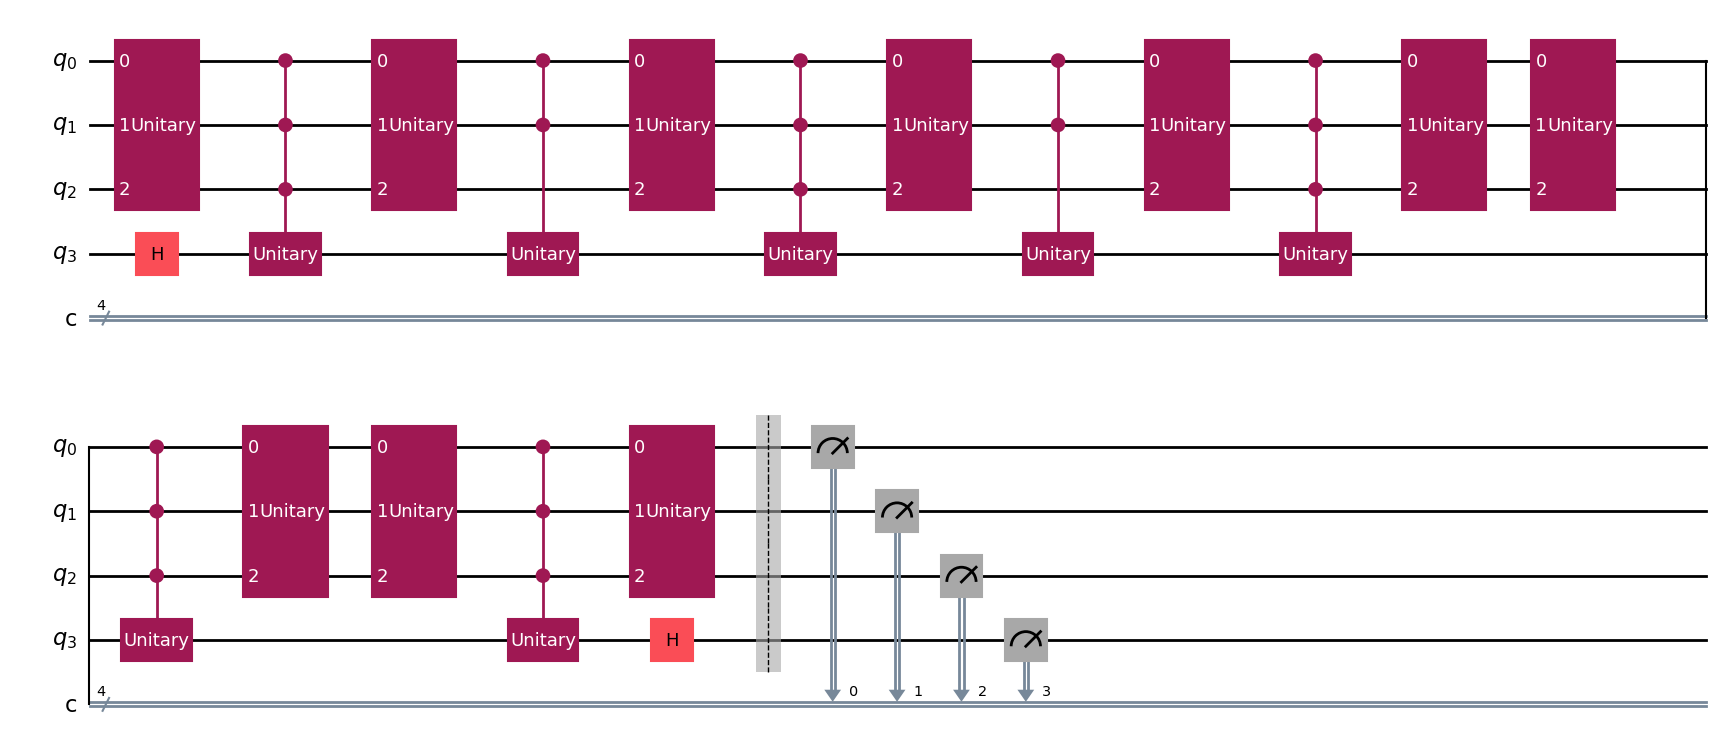

In [58]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n)  # Create circuit with only n qubits
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
theta = np.pi / 4  # Parameter for U_sin gate

phi = np.random.uniform(low=-np.pi, high=np.pi, size=(5,))  # Array of phi values
phi = list(phi)  # Convert to list to allow popping elements

# Random value of d (even or odd)
d = np.random.randint(1, 10)  # Random integer for testing (odd or even check)

# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  # n qubits + 1 auxiliary qubit

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n)

# Apply the U_sin(θ) gate repeatedly with phi values
for i in range(len(phi)):
    u_sin_gate = u_sin_theta_matrix(theta, n)
    qc.compose(u_sin_gate, qubits=range(n), inplace=True)

    # Pop the next value of phi for the controlled exponential gate
    if len(phi)!=1:
      current_phi_d = phi.pop()

    # Apply controlled exp gate based on the popped phi
    apply_exp_gate(qc, current_phi_d, control_qubits=list(range(n)), target=n)

    # Apply U† (inverse of U_sin)
    u_sin_dagger = u_sin_gate.inverse()
    qc.compose(u_sin_dagger, qubits=range(n), inplace=True)

    # Apply the second controlled exponential gate (if applicable)
    if i < len(phi):  # Make sure we have more phi values left
        next_phi_d = phi.pop(0)
        apply_exp_gate(qc, next_phi_d, control_qubits=list(range(n-1)), target=n)

# If d is odd, apply the final gates
if d % 2 != 0:
    u_sin_gate = u_sin_theta_matrix(theta, n)
    qc.compose(u_sin_gate, qubits=range(n), inplace=True)

    # Apply the last controlled exponential gate based on remaining phi
    if len(phi) > 0:
        last_phi_d = phi.pop(0)
        apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl')


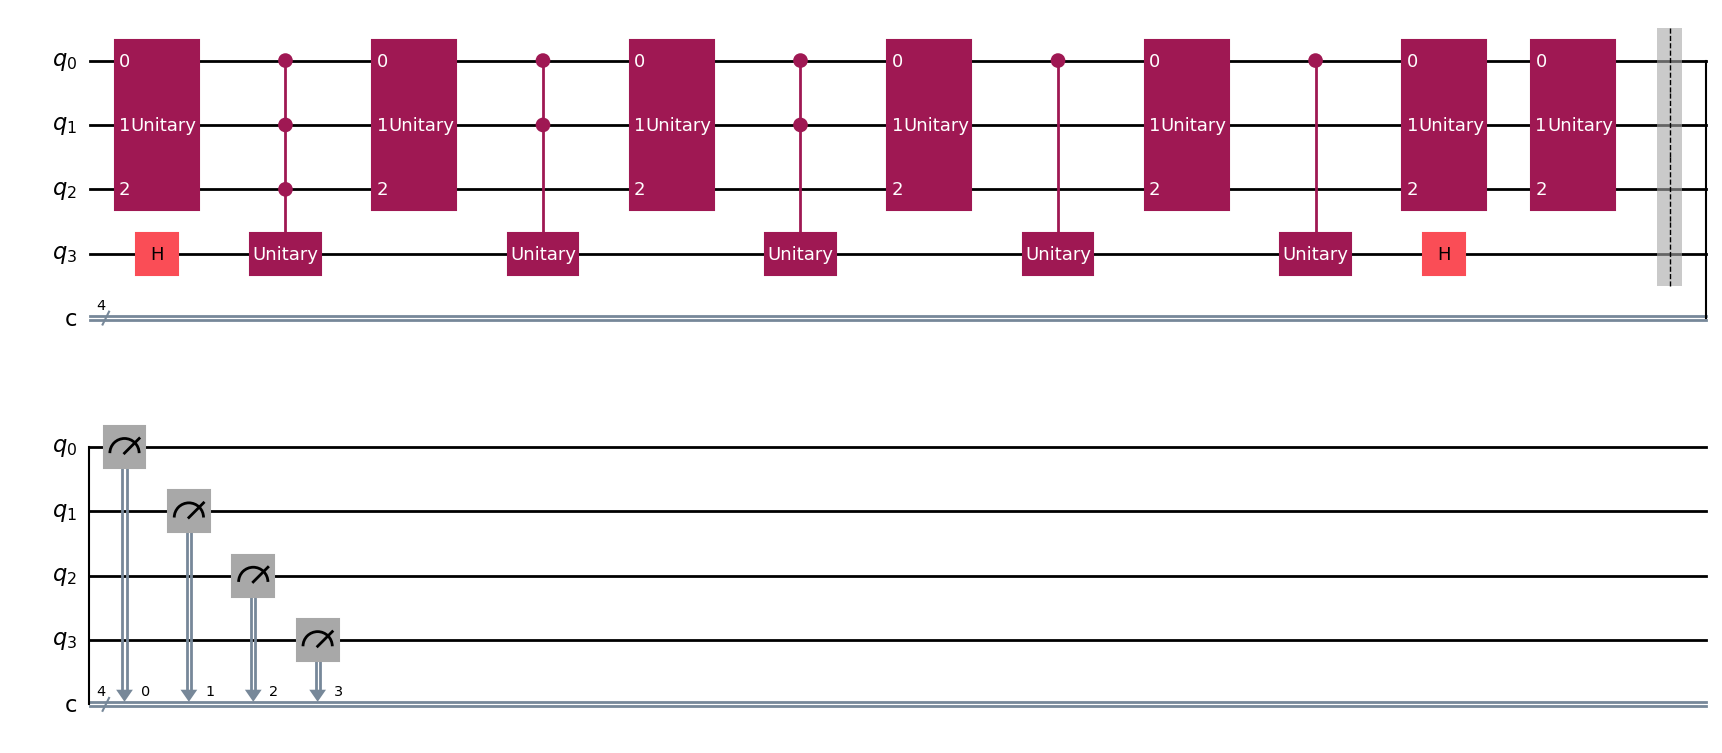

In [60]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n)  # Create circuit with only n qubits
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
theta = np.pi / 4  # Parameter for U_sin gate

# Adjust the number of required phi values
required_phi_count = 2 * n - 1  # Based on the number of controlled gates

phi = np.random.uniform(low=-np.pi, high=np.pi, size=(required_phi_count,))  # Array of phi values
phi = list(phi)  # Convert to list to allow popping elements

# Random value of d (even or odd)
d = np.random.randint(1, 10)  # Random integer for testing (odd or even check)

# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  # n qubits + 1 auxiliary qubit

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n)

# Apply the U_sin(θ) gate repeatedly with phi values
for i in range(n):
    u_sin_gate = u_sin_theta_matrix(theta, n)
    qc.compose(u_sin_gate, qubits=range(n), inplace=True)

    # Pop the next value of phi for the controlled exponential gate
    current_phi_d = phi.pop(0)

    # Apply controlled exp gate based on the popped phi
    # Adjust control qubits based on the value of i and d (as shown in the paper)
    control_qubits = list(range(n-i))  # Fewer controls as you go down the circuit
    apply_exp_gate(qc, current_phi_d, control_qubits=control_qubits, target=n)

    # Apply U† (inverse of U_sin)
    u_sin_dagger = u_sin_gate.inverse()
    qc.compose(u_sin_dagger, qubits=range(n), inplace=True)

    # Apply the second controlled exponential gate (if applicable)
    if i < n - 1:  # We need fewer controlled gates in the second half of the circuit
        next_phi_d = phi.pop(0)
        control_qubits = list(range(n-i-1))  # One fewer control qubit
        apply_exp_gate(qc, next_phi_d, control_qubits=control_qubits, target=n)

# If d is odd, apply the final gates
if d % 2 != 0:
    u_sin_gate = u_sin_theta_matrix(theta, n)
    qc.compose(u_sin_gate, qubits=range(n), inplace=True)
    qc.cx()
    # Apply the last controlled exponential gate based on remaining phi
    if len(phi) > 0:
        last_phi_d = phi.pop(0)
        apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl')


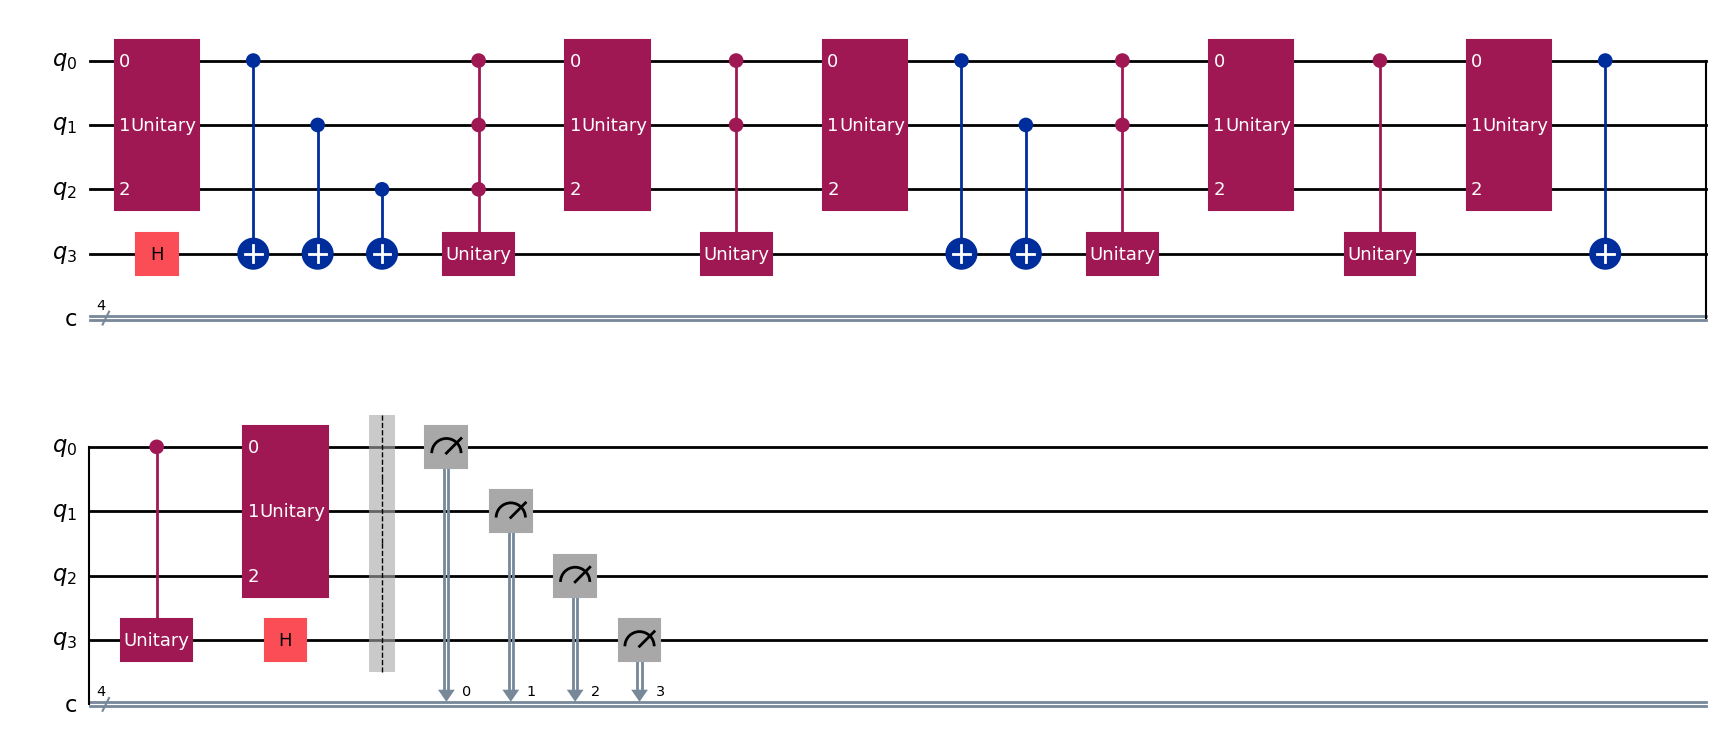

9


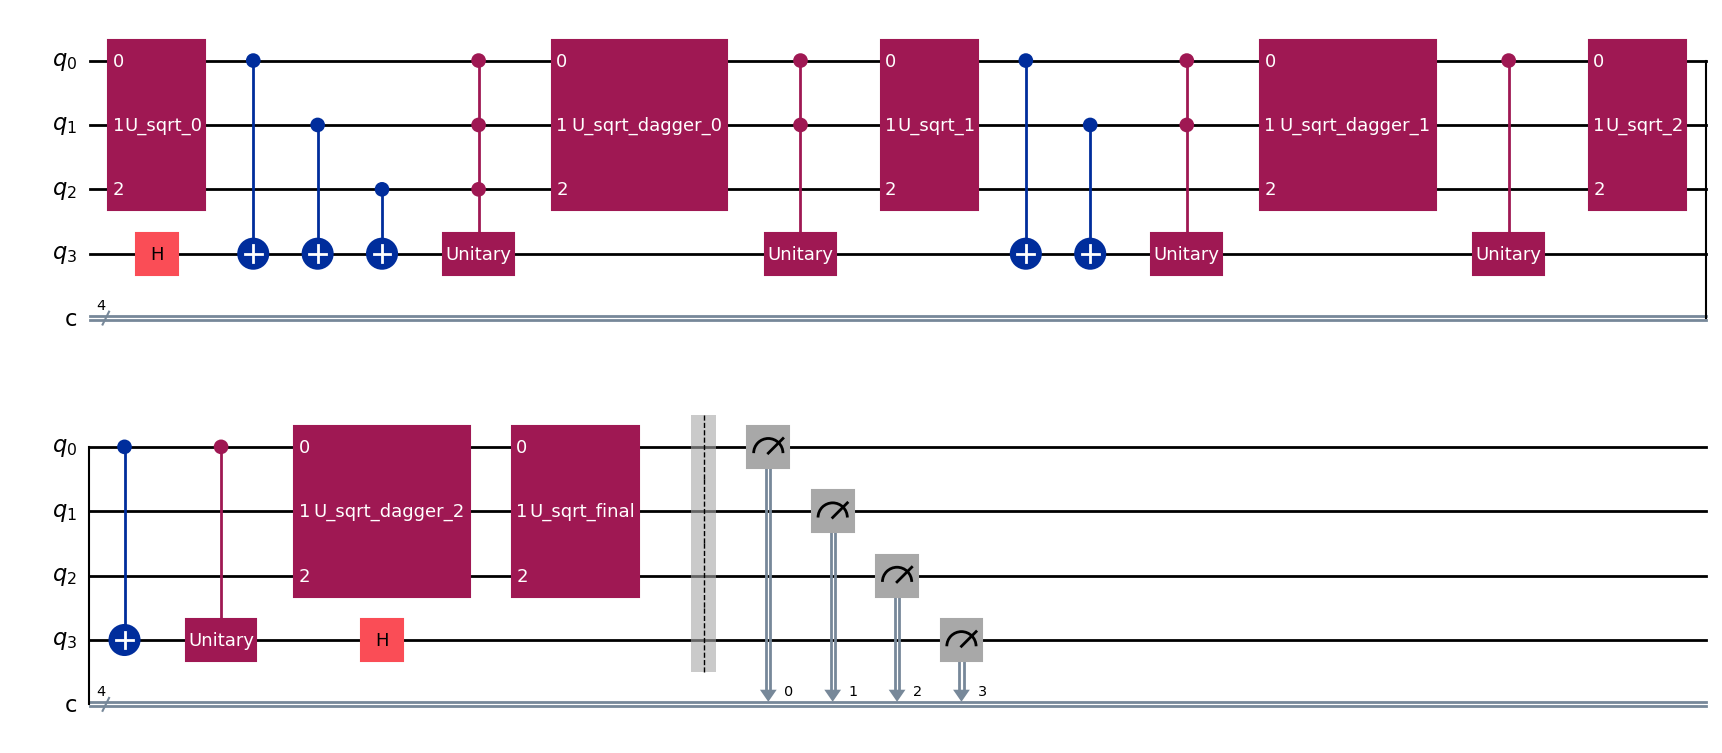

In [85]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator
from qiskit.circuit.library import UnitaryGate

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Function to create U_sqrt gate (treated as a blackbox)
def create_n_U_sqrt_blackbox(x, n):
    """
    Create the U_sqrt gate for n qubits and wrap it in a blackbox unitary.
    
    Args:
        x (float): Parameter for U_sqrt.
        n (int): Number of qubits.

    Returns:
        QuantumCircuit: A quantum circuit with U_sqrt gate.
    """
    # Ensure x is between 0 and 1
    if x < 0 or x > 1:
        raise ValueError("x must be between 0 and 1")

    # Calculate components
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)

    # Define the unitary matrix for the first qubit and identity for others
    unitary_matrix = np.zeros((2**n, 2**n), dtype=complex)

    # Fill in the matrix for the transformation
    for i in range(2**(n-1)):
        unitary_matrix[0 + 2*i][0 + 2*i] = sqrt_x   # |0...0> to sqrt(x)|0...0>
        unitary_matrix[0 + 2*i][1 + 2*i] = sqrt_1_minus_x  # |0...0> to sqrt(1-x)|1...0>
        unitary_matrix[1 + 2*i][0 + 2*i] = -sqrt_1_minus_x # |0...0> to -sqrt(1-x)|1...0>
        unitary_matrix[1 + 2*i][1 + 2*i] = sqrt_x   # |1...0> to sqrt(x)|1...0>

    # Create a quantum circuit to apply this unitary
    U_sqrt_blackbox = Operator(unitary_matrix)  # Blackbox operator
    
    return U_sqrt_blackbox

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
x = 0.5  # Parameter for U_sqrt gate, can be any value between 0 and 1

# Adjust the number of required phi values
required_phi_count = 2 * n - 1  # Based on the number of controlled gates

phi = np.random.uniform(low=-np.pi, high=np.pi, size=(required_phi_count,))  # Array of phi values
phi = list(phi)  # Convert to list to allow popping elements

# Random value of d (even or odd)
d = np.random.randint(1, 10)  # Random integer for testing (odd or even check)
print(d)
# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  # n qubits + 1 auxiliary qubit

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n)

# Apply the U_sqrt(x) gate repeatedly with phi values
for i in range(n):
    # Get the U_sqrt blackbox gate
    u_sqrt_blackbox = create_n_U_sqrt_blackbox(x, n)
    
    # Add the U_sqrt blackbox unitary to the circuit
    qc.unitary(u_sqrt_blackbox, qubits=range(n), label=f'U_sqrt_{i}')

    # Apply the CNOT (CX) gate between control and auxiliary qubit
    for j in range(n-i):
        qc.cx(j, n)  # Control on qubits 0 to n-i, targeting the auxiliary qubit

    # Pop the next value of phi for the controlled exponential gate
    current_phi_d = phi.pop(0)

    # Apply controlled exp gate based on the popped phi
    # Adjust control qubits based on the value of i and d (as shown in the paper)
    control_qubits = list(range(n-i))  # Fewer controls as you go down the circuit
    apply_exp_gate(qc, current_phi_d, control_qubits=control_qubits, target=n)

    # Apply U† (inverse of U_sqrt)
    u_sqrt_blackbox_dagger = u_sqrt_blackbox.adjoint()
    qc.unitary(u_sqrt_blackbox_dagger, qubits=range(n), label=f'U_sqrt_dagger_{i}')

    # Apply the second controlled exponential gate (if applicable)
    if i < n - 1:  # We need fewer controlled gates in the second half of the circuit
        next_phi_d = phi.pop(0)
        control_qubits = list(range(n-i-1))  # One fewer control qubit
        apply_exp_gate(qc, next_phi_d, control_qubits=control_qubits, target=n)

# If d is odd, apply the final gates
if d % 2 != 0:
    u_sqrt_blackbox = create_n_U_sqrt_blackbox(x, n)
    qc.unitary(u_sqrt_blackbox, qubits=range(n), label='U_sqrt_final')

    # Apply the last controlled exponential gate based on remaining phi
    if len(phi) > 0:
        last_phi_d = phi.pop(0)
        apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n)

qc.barrier()

# Measurement (optional, depending on your goal)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl')


In [81]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    # Create the base 2x2 U_sin(θ) matrix
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    
    # Construct the full unitary matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    # Convert to a Qiskit operator and create a circuit
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n)  # Create circuit with only n qubits
    qc.append(U_sin, qargs=list(range(n)))  # Apply U_sin on the first n qubits
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    # Multi-controlled gate, with controls on control_qubits and target being the last qubit
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
theta = np.pi / 4  # Parameter for U_sin gate

# Adjust the number of required phi values
d=2 # Based on the number of controlled gates

phi = np.random.uniform(low=-np.pi, high=np.pi, size=(required_phi_count,))  # Array of phi values
phi = list(phi)  # Convert to list to allow popping elements

# Random value of d (even or odd)
#d = np.random.randint(1, 10)  # Random integer for testing (odd or even check)

d=2
# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  # n qubits + 1 auxiliary qubit

# Apply Hadamard gate to the last auxiliary qubit
qc.h(n)

# Apply the U_sin(θ) gate repeatedly with phi values
for i in range(n):
    u_sin_gate = u_sin_theta_matrix(theta, n)
    # Add a label to the U_sin gate to treat it as a blackbox
    u_sin_blackbox = u_sin_gate.to_gate(label=f'U_sin_{i}')  
    qc.compose(u_sin_blackbox, qubits=range(n), inplace=True)

    # Apply the CNOT (CX) gate between control and auxiliary qubit
    for j in range(n-i):
        qc.cx(j, n)  # Control on qubits 0 to n-i, targeting the auxiliary qubit

    # Pop the next value of phi for the controlled exponential gate
    current_phi_d = phi.pop(0)

    # Apply controlled exp gate based on the popped phi
    # Adjust control qubits based on the value of i and d (as shown in the paper)
    control_qubits = list(range(n-i))  # Fewer controls as you go down the circuit
    apply_exp_gate(qc, current_phi_d, control_qubits=control_qubits, target=n)

    # Apply U† (inverse of U_sin)
    u_sin_dagger = u_sin_gate.inverse()
    # Add a label to the U_sin dagger gate to treat it as a blackbox
    u_sin_dagger_blackbox = u_sin_dagger.to_gate(label=f'U_sin†_{i}')
    qc.compose(u_sin_dagger_blackbox, qubits=range(n), inplace=True)

    qc.barrier()
    if i < n - 1:  # We need fewer controlled gates in the second half of the circuit
        next_phi_d = phi.pop(0)
        control_qubits = list(range(n-i-1))  # One fewer control qubit
        apply_exp_gate(qc, next_phi_d, control_qubits=control_qubits, target=n)

# If d is odd, apply the final gates
if d % 2 != 0:
    u_sin_gate = u_sin_theta_matrix(theta, n)
    # Add a label to the U_sin gate to treat it as a blackbox
    u_sin_blackbox_final = u_sin_gate.to_gate(label='U_sin_final')
    qc.compose(u_sin_blackbox_final, qubits=range(n), inplace=True)

    # Apply the last controlled exponential gate based on remaining phi
    if len(phi) > 0:
        last_phi_d = phi.pop(0)
        apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

# Final Hadamard gate on the last auxiliary qubit
qc.h(n)

# Measurement (optional, depending on your goal)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl',fold=-1,interactive=True)


IndexError: pop from empty list

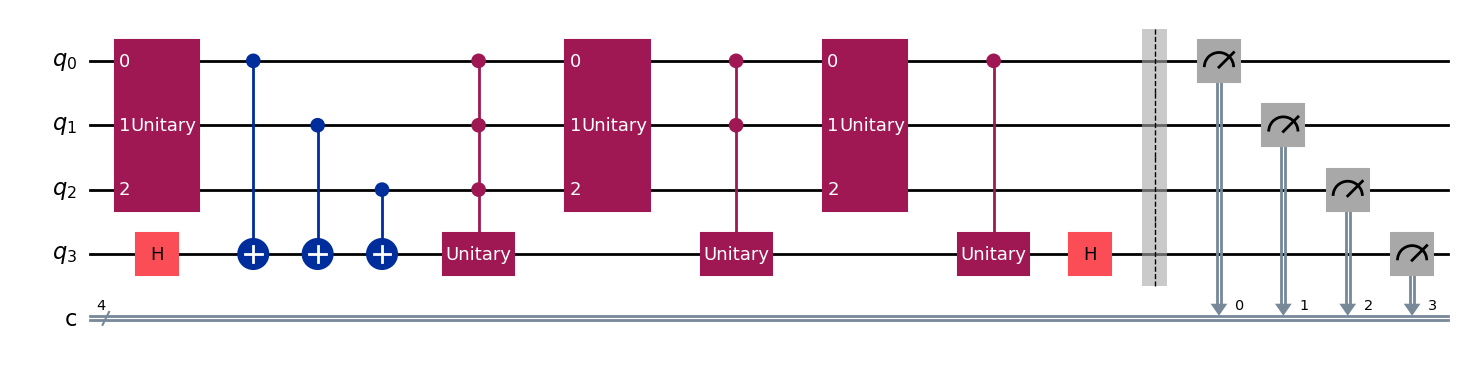

In [79]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to generate U_sqrt as a blackbox
def create_n_U_sqrt(x, n):
    """
    Generates the U_sqrt unitary matrix for n qubits.
    """
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)
    unitary_matrix = np.zeros((2**n, 2**n), dtype=complex)

    # Fill in the matrix
    for i in range(2**(n-1)):
        unitary_matrix[0 + 2*i][0 + 2*i] = sqrt_x
        unitary_matrix[0 + 2*i][1 + 2*i] = sqrt_1_minus_x
        unitary_matrix[1 + 2*i][0 + 2*i] = -sqrt_1_minus_x
        unitary_matrix[1 + 2*i][1 + 2*i] = sqrt_x

    U_sqrt = Operator(unitary_matrix)
    qc = QuantumCircuit(n)
    qc.append(U_sqrt, qargs=list(range(n)))
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
x = 0.6  # Parameter for U_sqrt gate

# Adjust the number of required phi values
required_phi_count = 3 # Based on the number of controlled gates
phi = np.random.uniform(low=-np.pi, high=np.pi, size=(required_phi_count,))
phi = list(phi)  # Convert to list to allow popping elements

# Random value of d (even or odd)
d = 3

# Create the quantum circuit
qc = QuantumCircuit(n + 1, n + 1)  # n qubits + 1 auxiliary qubit

# Apply Hadamard gate to the auxiliary qubit
qc.h(n)

# First layer: Apply U_sqrt gate and the first set of controlled operations
u_sqrt_gate = create_n_U_sqrt(x, n)
qc.compose(u_sqrt_gate, qubits=range(n), inplace=True)

# Apply controlled gates between control qubits and auxiliary qubit
for i in range(n):
    qc.cx(i, n)

# First controlled exponential gate
current_phi_d = phi.pop(0)
apply_exp_gate(qc, current_phi_d, control_qubits=list(range(n)), target=n)

# Apply U† (inverse of U_sqrt)
u_sqrt_dagger = u_sqrt_gate.inverse()
qc.compose(u_sqrt_dagger, qubits=range(n), inplace=True)

# Apply the second controlled exponential gate
next_phi_d = phi.pop(0)
apply_exp_gate(qc, next_phi_d, control_qubits=list(range(n-1)), target=n)

# If d is odd, apply the final U_sqrt gate and exponential gate
if d % 2 != 0:
    qc.compose(u_sqrt_gate, qubits=range(n), inplace=True)
    last_phi_d = phi.pop(0)
    apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

# Final Hadamard gate on the auxiliary qubit
qc.h(n)

qc.barrier()

# Measurement (optional)
qc.measure(range(n + 1), range(n + 1))

# Draw the circuit
qc.draw('mpl')


In [94]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Helper function to apply U_sin(θ) unitary
def u_sin_theta_matrix(x, n):
    """
    Generates the U_sin(θ) unitary matrix for n qubits.
    
    Args:
        x (float): Angle parameter for U_sin.
        n (int): Number of qubits in the main register.
        
    Returns:
        QuantumCircuit: Circuit with U_sin(θ) gate applied.
    """
    base_matrix = np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    U_sin = Operator(u_matrix) 
    qc = QuantumCircuit(n)
    qc.append(U_sin, qargs=list(range(n)))
    return qc

# Helper function to generate U_sqrt as a blackbox
def create_n_U_sqrt(x, n):
    """
    Generates the U_sqrt unitary matrix for n qubits.
    """
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)
    unitary_matrix = np.zeros((2**n, 2**n), dtype=complex)

    for i in range(2**(n-1)):
        unitary_matrix[0 + 2*i][0 + 2*i] = sqrt_x
        unitary_matrix[0 + 2*i][1 + 2*i] = sqrt_1_minus_x
        unitary_matrix[1 + 2*i][0 + 2*i] = -sqrt_1_minus_x
        unitary_matrix[1 + 2*i][1 + 2*i] = sqrt_x

    U_sqrt = Operator(unitary_matrix)
    qc = QuantumCircuit(n)
    qc.append(U_sqrt, qargs=list(range(n)))
    return qc

# Helper function to apply the controlled exponential gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    """
    Apply controlled exp(-i * phi_d * Z) gate on target qubit controlled by a list of control_qubits.
    """
    unitary = np.array([
        [np.exp(-1j * phi_d), 0],
        [0, np.exp(1j * phi_d)]
    ])
    gate = UnitaryGate(unitary)
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Main function to construct the quantum circuit
def construct_qsp_circuit(n, x, phi_values, unitary_type='U_sin'):
    """
    Constructs the quantum circuit for QSP with either U_sin or U_sqrt.
    
    Args:
        n (int): Number of qubits in the main register.
        x (float): Parameter for U_sqrt gate.
        phi_values (list): List of phi parameters for controlled phase gates.
        unitary_type (str): Choose between 'U_sin' and 'U_sqrt'.
        
    Returns:
        QuantumCircuit: Constructed quantum circuit for QSP.
    """
    # Ensure that phi_values has n-1 repetitions
    assert len(phi_values) == 2 * n - 1, "phi_values must have 2n-1 entries."

    # Random d for testing purposes (odd/even)
    d = 5
    
    # Create the quantum circuit (n main qubits + 1 auxiliary qubit)
    qc = QuantumCircuit(n + 1, n + 1)

    # Apply Hadamard gate to the auxiliary qubit
    qc.h(n)

    # Define which unitary to use: U_sin or U_sqrt
    if unitary_type == 'U_sin':
        create_U_gate = lambda: u_sin_theta_matrix(x, n)
        unitary_label = 'U_sin(θ)'
    else:
        create_U_gate = lambda: create_n_U_sqrt(x, n)
        unitary_label = 'U_sqrt(x)'

    # Loop through the number of layers for QSP (n-1 repetitions of blocks)
    for i in range(d-1):
        # Apply U or U_sqrt
        U_gate = create_U_gate()
        U_dagger = U_gate.inverse()
        qc.append(U_gate.to_gate(label=f'{unitary_label}'), qargs=range(n))

        # Apply the multi-controlled CNOT gates
        for j in range(n - i):
            qc.cx(j, n)

        # Apply the first controlled exponential gate
        current_phi_d = phi_values.pop(0)
        apply_exp_gate(qc, current_phi_d, control_qubits=list(range(n)), target=n)

        # Apply U† (inverse of U)
        qc.append(U_dagger.to_gate(label=f'{unitary_label}†'), qargs=range(n))

        # Apply the second controlled exponential gate
        if i < d - 2:
            next_phi_d = phi_values.pop(0)
            apply_exp_gate(qc, next_phi_d, control_qubits=list(range(n - 1 - i)), target=n)

    # If d is odd, apply the final U and controlled exponential gate
    if d % 2 != 0:
        U_gate = create_U_gate()
        qc.append(U_gate.to_gate(label=f'{unitary_label}'), qargs=range(n))
        last_phi_d = phi_values.pop(0)
        apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

    # Final Hadamard gate on the auxiliary qubit
    qc.h(n)

    # Barrier for clarity
    qc.barrier()

    # Measurement (optional)
    qc.measure(range(n + 1), range(n + 1))

    return qc

# Define parameters for the circuit
n = 3  # Number of qubits in the main register (n qubits for U and U†)
x = 0.6  # Parameter for U_sqrt gate (or angle for U_sin)

# Adjust the number of required phi values
required_phi_count = 2 * n - 1  # Based on the number of controlled gates
phi_values = list(np.random.uniform(low=-np.pi, high=np.pi, size=(required_phi_count,)))

# Construct the circuit for U_sin(θ)
qsp_circuit_U_sin = construct_qsp_circuit(n, np.pi / 4, phi_values.copy(), unitary_type='U_sin')

# Construct the circuit for U_sqrt(x)
qsp_circuit_U_sqrt = construct_qsp_circuit(n, x, phi_values.copy(), unitary_type='U_sqrt')

# Draw the circuits (optional)
qsp_circuit_U_sin.draw('mpl')



IndexError: pop from empty list

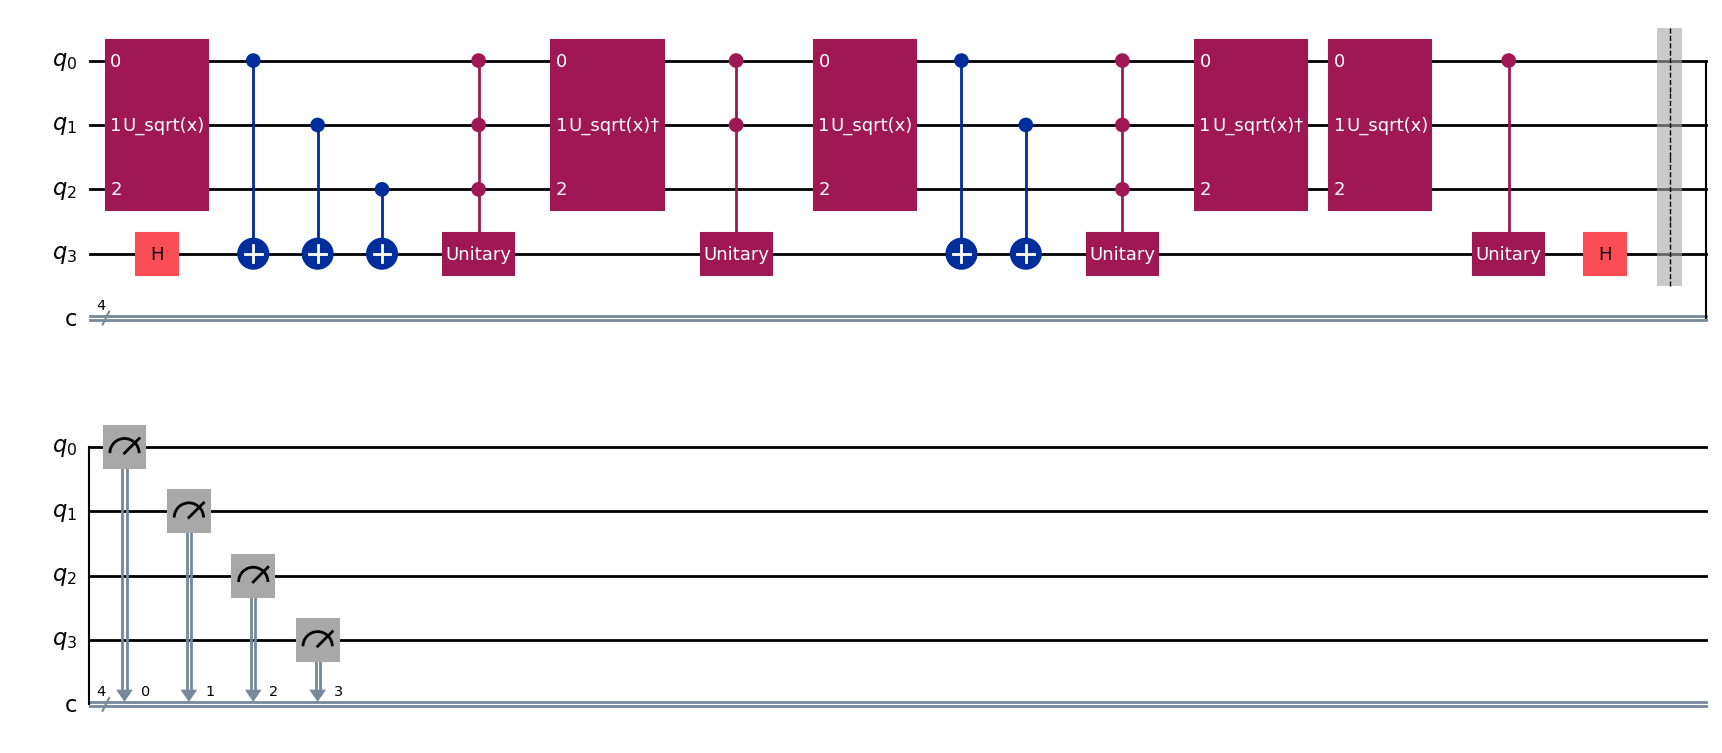

In [93]:
qsp_circuit_U_sqrt.draw('mpl')

In [113]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator

# Function to generate U_sin(θ) unitary matrix
def u_sin_theta_matrix(x, n):
    base_matrix = np.array([[np.cos(x), -np.sin(x)],
                            [np.sin(x), np.cos(x)]])
    u_matrix = base_matrix
    for _ in range(n-1):
        u_matrix = np.kron(u_matrix, base_matrix)
        
    U_sin = Operator(u_matrix)
    qc = QuantumCircuit(n)
    qc.append(U_sin, qargs=list(range(n)))
    return qc

# Function to apply controlled exp(-i * phi_d * Z) gate
def apply_exp_gate(circuit, phi_d, control_qubits, target):
    unitary = np.array([[np.exp(-1j * phi_d), 0],
                        [0, np.exp(1j * phi_d)]])
    gate = UnitaryGate(unitary)
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])

# Function to construct the quantum circuit for U_sin
def build_circuit_U_sin(d, phi):
    n = len(phi) - 1  # Number of repeats is len(phi)-1
    theta = np.pi / 4  # Parameter for U_sin gate
    
    qc = QuantumCircuit(n + 1, n + 1)
    qc.h(n)

    for i in range(n):
        u_sin_gate = u_sin_theta_matrix(theta, n)
        qc.compose(u_sin_gate, qubits=range(n), inplace=True)

        for j in range(n-i):
            qc.cx(j, n)  # CNOT between control qubits and auxiliary qubit

        current_phi_d = phi[i]
        control_qubits = list(range(n-i))
        apply_exp_gate(qc, current_phi_d, control_qubits=control_qubits, target=n)

        u_sin_dagger = u_sin_gate.inverse()
        qc.compose(u_sin_dagger, qubits=range(n), inplace=True)
        
        qc.barrier()
        
        if i < n - 1:
            next_phi_d = phi[i+1]
            control_qubits = list(range(n-i-1))
            apply_exp_gate(qc, next_phi_d, control_qubits=control_qubits, target=n)

    if d % 2 != 0:
        u_sin_gate = u_sin_theta_matrix(theta, n)
        qc.compose(u_sin_gate, qubits=range(n), inplace=True)
        if len(phi) > 0:
            last_phi_d = phi[-1]
            apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

    qc.h(n)
    qc.barrier()
    qc.measure(range(n + 1), range(n + 1))
    
    return qc
d=5
phi=np.random.uniform(-np.pi,np.pi,size=(d,))

qc_sin=build_circuit_U_sin(d,phi)


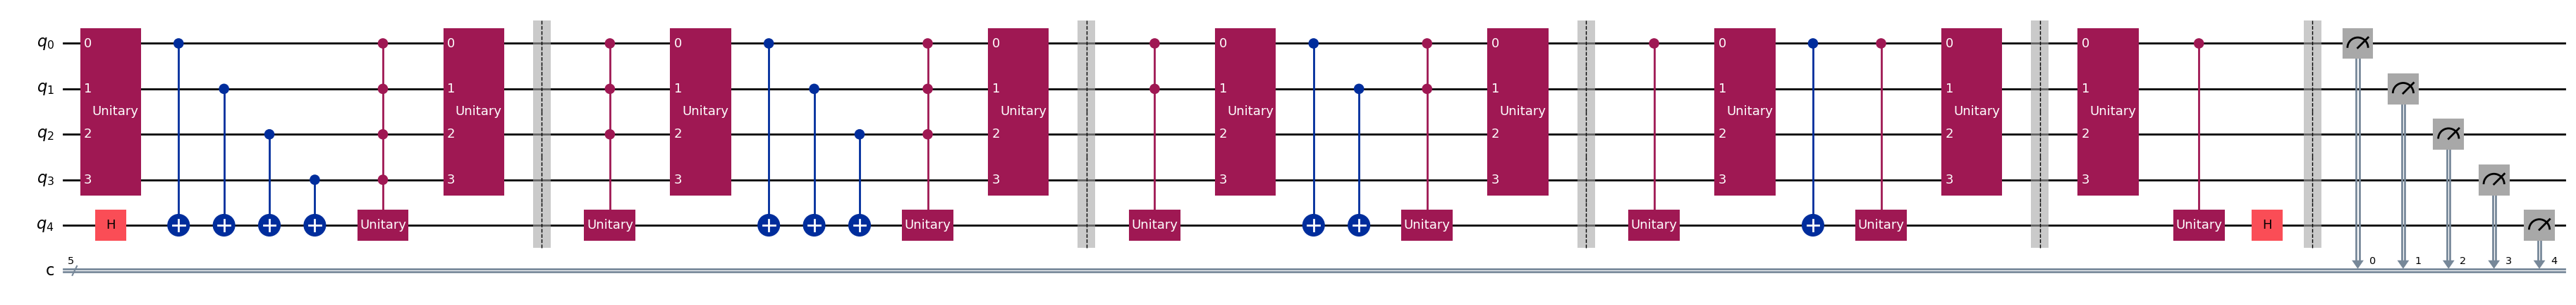

In [114]:
qc_sin.draw(output="mpl",fold=-1)

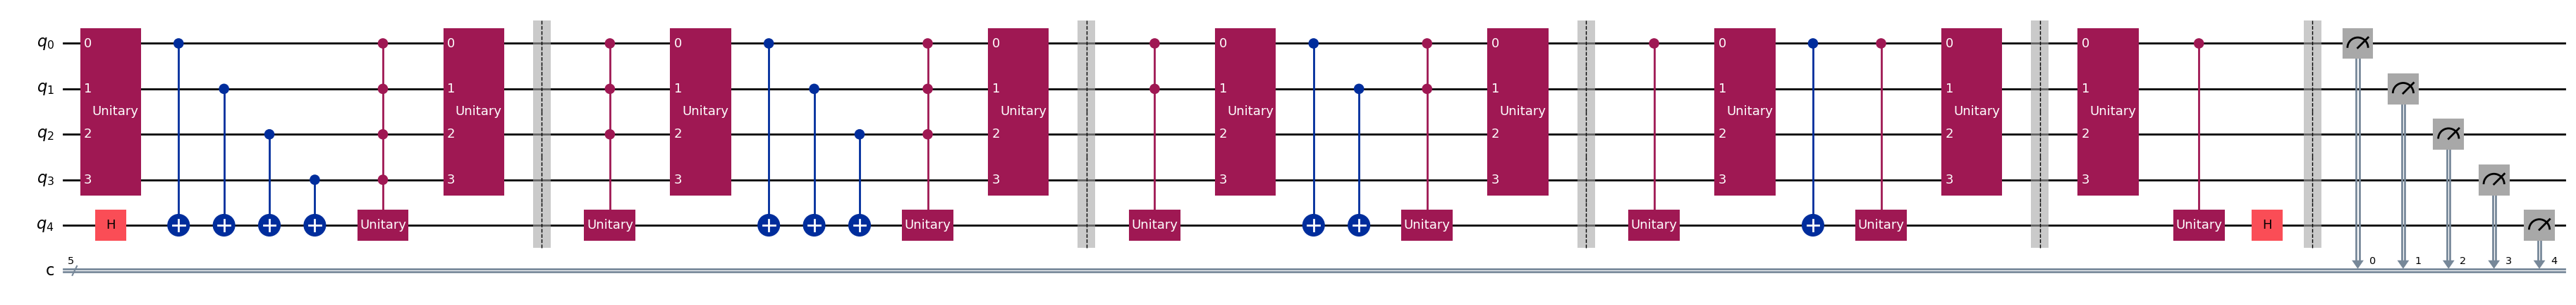

In [115]:
def create_n_U_sqrt(x, n):
    sqrt_x = np.sqrt(x)
    sqrt_1_minus_x = np.sqrt(1 - x)

    unitary_matrix = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**(n-1)):
        unitary_matrix[0 + 2*i][0 + 2*i] = sqrt_x
        unitary_matrix[0 + 2*i][1 + 2*i] = sqrt_1_minus_x
        unitary_matrix[1 + 2*i][0 + 2*i] = -sqrt_1_minus_x
        unitary_matrix[1 + 2*i][1 + 2*i] = sqrt_x

    U_sqrt = Operator(unitary_matrix)
    qc = QuantumCircuit(n)
    qc.append(U_sqrt, qargs=list(range(n)))
    return qc

# Function to construct the quantum circuit for U_sqrt
def build_circuit_U_sqrt(d, phi):
    n = len(phi) - 1  # Number of repeats is len(phi)-1
    x = 0.5  # Some parameter for U_sqrt (you can change it as needed)
    
    qc = QuantumCircuit(n + 1, n + 1)
    qc.h(n)

    for i in range(n):
        u_sqrt_gate = create_n_U_sqrt(x, n)
        qc.compose(u_sqrt_gate, qubits=range(n), inplace=True)

        for j in range(n-i):
            qc.cx(j, n)  # CNOT between control qubits and auxiliary qubit

        current_phi_d = phi[i]
        control_qubits = list(range(n-i))
        apply_exp_gate(qc, current_phi_d, control_qubits=control_qubits, target=n)

        u_sqrt_dagger = u_sqrt_gate.inverse()
        qc.compose(u_sqrt_dagger, qubits=range(n), inplace=True)
        
        qc.barrier()

        if i < n - 1:
            next_phi_d = phi[i+1]
            control_qubits = list(range(n-i-1))
            apply_exp_gate(qc, next_phi_d, control_qubits=control_qubits, target=n)

    if d % 2 != 0:
        u_sqrt_gate = create_n_U_sqrt(x, n)
        qc.compose(u_sqrt_gate, qubits=range(n), inplace=True)
        if len(phi) > 0:
            last_phi_d = phi[-1]
            apply_exp_gate(qc, last_phi_d, control_qubits=[0], target=n)

    qc.h(n)
    qc.barrier()
    qc.measure(range(n + 1), range(n + 1))
    
    return qc
d=5
phi=np.random.uniform(-np.pi,np.pi,size=(d,))
qc_sqrt=build_circuit_U_sqrt(d,phi)

qc_sqrt.draw(fold=-1,output="mpl")

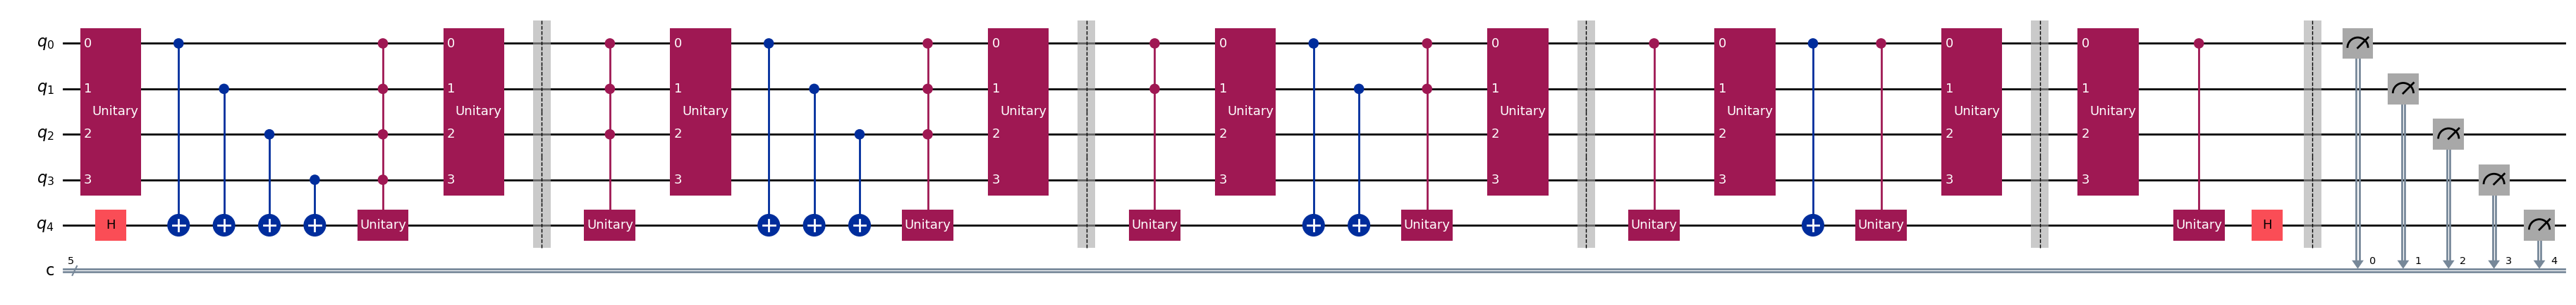

In [116]:
qc_sin.draw(output="mpl",fold=-1)

In [117]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

service=QiskitRuntimeService()
backend=service.backend("ibm_brisbane")


In [119]:
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

def generate_sqrt(n):
    size=n
    params=np.random.uniform(-np.pi,np.pi,size=(size,))
    qc_sqrt=build_circuit_U_sqrt(size,params)

    isa_qc=pm.run(qc_sqrt)

    return isa_qc.depth()
def generate_sin(n):
    size=n
    params=np.random.uniform(-np.pi,np.pi,size=(size,))
    qc_sin=build_circuit_U_sin(size,params)

    isa_qc=pm.run(qc_sin)

    return isa_qc.depth()


In [124]:
qubits=[i for i in range (2,7)]

sqrt=[generate_sqrt(i) for i in qubits]
sin=[generate_sin(i) for i in qubits]


In [123]:
sin

[11, 61, 702]

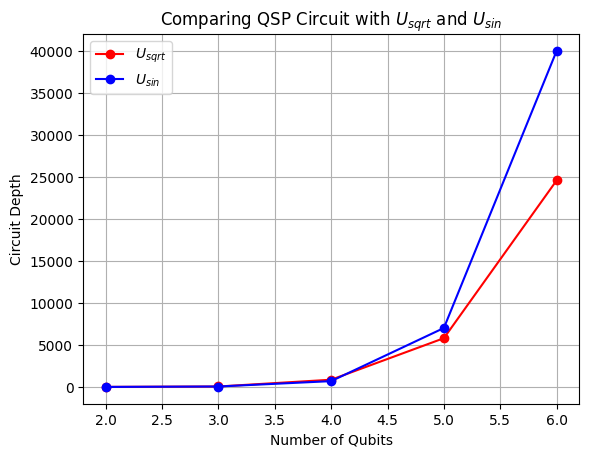

In [128]:
plt.plot(qubits,sqrt,"ro-",label=r"$U_{sqrt}$")
plt.plot(qubits,sin,"bo-",label=r"$U_{sin}$")
plt.legend()
plt.grid(True)
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title(r"Comparing QSP Circuit with $U_{sqrt}$ and $U_{sin}$")
plt.show()